In [ ]:
# Install required packages
!pip install -q pandas numpy matplotlib seaborn
!pip install -q scikit-learn
!pip install -q pillow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import os
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set your paths - UPDATED to match your folder structure
BASE_DIR = '/content/drive/MyDrive/MedicalReportGenerator'
DATA_DIR = os.path.join(BASE_DIR, 'data')

# File paths
REPORTS_CSV = os.path.join(DATA_DIR, 'indiana_reports.csv')
PROJECTIONS_CSV = os.path.join(DATA_DIR, 'indiana_projections.csv')

# FIXED: Your images are in "images_normalized" folder, not "images"
IMAGE_DIR = os.path.join(DATA_DIR, 'images_normalized')  # ← CHANGED THIS

# Create output directory
PROCESSED_DIR = os.path.join(DATA_DIR, 'processed')
os.makedirs(PROCESSED_DIR, exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Image directory: {IMAGE_DIR}")
print(f"Processed output: {PROCESSED_DIR}")

# Verify the image directory exists
if os.path.exists(IMAGE_DIR):
    image_count = len([f for f in os.listdir(IMAGE_DIR) if f.endswith('.png')])
    print(f"\n✓ Image directory found with {image_count} PNG files")
else:
    print(f"\n❌ Image directory not found: {IMAGE_DIR}")

Mounted at /content/drive
Data directory: /content/drive/MyDrive/MedicalReportGenerator/data
Image directory: /content/drive/MyDrive/MedicalReportGenerator/data/images_normalized
Processed output: /content/drive/MyDrive/MedicalReportGenerator/data/processed

✓ Image directory found with 6535 PNG files


In [ ]:
# Load both CSV files
print("Loading CSV files...")
reports_df = pd.read_csv(REPORTS_CSV)
projections_df = pd.read_csv(PROJECTIONS_CSV)

print(f"\n📊 Dataset Overview:")
print(f"Reports shape: {reports_df.shape}")
print(f"Projections shape: {projections_df.shape}")

print(f"\n📋 Reports columns: {list(reports_df.columns)}")
print(f"📋 Projections columns: {list(projections_df.columns)}")

# Display first few rows
print("\n🔍 Sample Reports:")
print(reports_df.head(3))

print("\n🔍 Sample Projections:")
print(projections_df.head(6))

Loading CSV files...

📊 Dataset Overview:
Reports shape: (3851, 8)
Projections shape: (7466, 3)

📋 Reports columns: ['uid', 'MeSH', 'Problems', 'image', 'indication', 'comparison', 'findings', 'impression']
📋 Projections columns: ['uid', 'filename', 'projection']

🔍 Sample Reports:
   uid                                               MeSH  \
0    1                                             normal   
1    2  Cardiomegaly/borderline;Pulmonary Artery/enlarged   
2    3                                             normal   

                        Problems                                image  \
0                         normal            Xray Chest PA and Lateral   
1  Cardiomegaly;Pulmonary Artery  Chest, 2 views, frontal and lateral   
2                         normal            Xray Chest PA and Lateral   

                                          indication comparison  \
0                                   Positive TB test      None.   
1                           Preop bariatric s

In [ ]:
"""
As per paper Section IV.A:
"The dataset used in this study is open data from the Indiana University Hospital"
We use only Frontal projections for consistency in report generation
"""

print("Original projections distribution:")
print(projections_df['projection'].value_counts())

# Filter only Frontal images
frontal_df = projections_df[projections_df['projection'] == 'Frontal'].copy()

print(f"\n✓ Filtered to Frontal images only")
print(f"Frontal images: {len(frontal_df)}")
print(f"Removed Lateral images: {len(projections_df) - len(frontal_df)}")

# Display sample
print("\n🔍 Sample Frontal projections:")
print(frontal_df.head())

Original projections distribution:
projection
Frontal    3818
Lateral    3648
Name: count, dtype: int64

✓ Filtered to Frontal images only
Frontal images: 3818
Removed Lateral images: 3648

🔍 Sample Frontal projections:
   uid                   filename projection
0    1     1_IM-0001-4001.dcm.png    Frontal
2    2     2_IM-0652-1001.dcm.png    Frontal
4    3     3_IM-1384-1001.dcm.png    Frontal
6    4     4_IM-2050-1001.dcm.png    Frontal
8    5  5_IM-2117-1003002.dcm.png    Frontal


In [ ]:
"""
Merge reports with frontal image filenames
Keep only necessary columns from reports
"""

# Select necessary columns from reports
# As per paper: uid, findings, impression, Problems (for classification)
reports_selected = reports_df[['uid', 'findings', 'impression', 'Problems']].copy()

print(f"Reports before merge: {len(reports_selected)}")
print(f"Frontal images: {len(frontal_df)}")

# Merge on 'uid'
merged_df = frontal_df.merge(reports_selected, on='uid', how='inner')

print(f"\n✓ Merged dataset: {len(merged_df)} samples")
print(f"Columns: {list(merged_df.columns)}")

# Display sample
print("\n🔍 Sample merged data:")
print(merged_df[['uid', 'filename', 'Problems']].head())

Reports before merge: 3851
Frontal images: 3818

✓ Merged dataset: 3818 samples
Columns: ['uid', 'filename', 'projection', 'findings', 'impression', 'Problems']

🔍 Sample merged data:
   uid                   filename  \
0    1     1_IM-0001-4001.dcm.png   
1    2     2_IM-0652-1001.dcm.png   
2    3     3_IM-1384-1001.dcm.png   
3    4     4_IM-2050-1001.dcm.png   
4    5  5_IM-2117-1003002.dcm.png   

                                            Problems  
0                                             normal  
1                      Cardiomegaly;Pulmonary Artery  
2                                             normal  
3  Pulmonary Disease, Chronic Obstructive;Bullous...  
4                         Osteophyte;Thickening;Lung  


In [ ]:
"""
Create full image paths and verify images exist
Remove entries where images are missing
"""

print("🔍 Creating image paths...")
print(f"IMAGE_DIR: {IMAGE_DIR}")

# Verify directory exists
if not os.path.exists(IMAGE_DIR):
    print(f"\n❌ ERROR: Image directory does not exist!")
    print(f"Path: {IMAGE_DIR}")
    print("\n🔧 Please check:")
    print("1. Is the folder name correct? (images_normalized)")
    print("2. Is the BASE_DIR path correct?")
    raise FileNotFoundError(f"Image directory not found: {IMAGE_DIR}")

# List some files to verify
image_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith('.png')]
print(f"\n ✓ Found {len(image_files)} PNG images in directory")

print("\n🔍 First 5 image files in folder:")
for i, f in enumerate(image_files[:5]):
    print(f"  {i+1}. {f}")

print("\n🔍 First 5 filenames from CSV:")
for i, f in enumerate(merged_df['filename'].head(5)):
    print(f"  {i+1}. {f}")

print("\n" + "="*70)

# Create image path column
merged_df['image_path'] = merged_df['filename'].apply(
    lambda x: os.path.join(IMAGE_DIR, x)
)

# Check a few examples
print("\n🔍 Testing first 3 paths:")
for i in range(min(3, len(merged_df))):
    path = merged_df.iloc[i]['image_path']
    filename = merged_df.iloc[i]['filename']
    exists = os.path.exists(path)
    status = "✓ EXISTS" if exists else "✗ NOT FOUND"
    print(f"{i+1}. {status}: {filename}")

print("\n" + "="*70)
print("Checking all image paths...")

# Check which images exist
merged_df['image_exists'] = merged_df['image_path'].apply(os.path.exists)

images_found = merged_df['image_exists'].sum()
images_missing = (~merged_df['image_exists']).sum()

print(f"\n📊 Results:")
print(f"Images found: {images_found} ({images_found/len(merged_df)*100:.1f}%)")
print(f"Images missing: {images_missing} ({images_missing/len(merged_df)*100:.1f}%)")

if images_missing > 0:
    print(f"\n⚠️ Warning: {images_missing} images not found")
    print("\n🔍 Sample missing filenames:")
    missing_files = merged_df[~merged_df['image_exists']]['filename'].head(5)
    for i, f in enumerate(missing_files, 1):
        print(f"  {i}. {f}")

    print("\n💡 These images are in the CSV but not in the images folder")

# Keep only rows where images exist
print("\n🔧 Filtering to keep only samples with existing images...")
merged_df = merged_df[merged_df['image_exists']].copy()
merged_df = merged_df.drop('image_exists', axis=1)

print(f"\n✓ Final dataset after verification: {len(merged_df)} samples")

if len(merged_df) > 0:
    # Display sample
    print("\n🔍 Sample data with verified paths:")
    sample_display = merged_df[['uid', 'filename', 'Problems']].head(3)
    print(sample_display)

    # Show a path example
    print(f"\n📂 Example image path:")
    print(f"   {merged_df.iloc[0]['image_path']}")
else:
    print("\n❌ ERROR: No images found! Please check your paths.")



🔍 Creating image paths...
IMAGE_DIR: /content/drive/MyDrive/MedicalReportGenerator/data/images_normalized

 ✓ Found 6535 PNG images in directory

🔍 First 5 image files in folder:
  1. 286_IM-1267-2001.dcm.png
  2. 3689_IM-1840-2001.dcm.png
  3. 1652_IM-0428-2001.dcm.png
  4. 3240_IM-1534-1001.dcm.png
  5. 668_IM-2242-2001.dcm.png

🔍 First 5 filenames from CSV:
  1. 1_IM-0001-4001.dcm.png
  2. 2_IM-0652-1001.dcm.png
  3. 3_IM-1384-1001.dcm.png
  4. 4_IM-2050-1001.dcm.png
  5. 5_IM-2117-1003002.dcm.png


🔍 Testing first 3 paths:
1. ✓ EXISTS: 1_IM-0001-4001.dcm.png
2. ✓ EXISTS: 2_IM-0652-1001.dcm.png
3. ✓ EXISTS: 3_IM-1384-1001.dcm.png

Checking all image paths...

📊 Results:
Images found: 3369 (88.2%)
Images missing: 449 (11.8%)

⚠️ Warning: 449 images not found

🔍 Sample missing filenames:
  1. 18_IM-0520-1001.dcm.png
  2. 27_IM-1168-2002.dcm.png
  3. 28_IM-1231-1001.dcm.png
  4. 51_IM-2125-1001.dcm.png
  5. 65_IM-2228-4004.dcm.png

💡 These images are in the CSV but not in the images fo

ANALYZING FINDINGS AND IMPRESSION PATTERNS

PART 1: BASIC STATISTICS

📊 Findings Column:
  Total entries: 3369
  Non-null: 2907
  Null/Empty: 462
  Average length: 218.0 characters
  Median length: 205.0 characters
  Min length: 33
  Max length: 1054

📊 Impression Column:
  Total entries: 3369
  Non-null: 3343
  Null/Empty: 26
  Average length: 76.5 characters
  Median length: 39.0
  Min length: 5
  Max length: 887

PART 2: XXXX PATTERN ANALYSIS

📊 XXXX Patterns in Findings:
  Reports with XXXX: 1213 (36.0%)

📊 XXXX Patterns in Impression:
  Reports with XXXX: 557 (16.5%)

🔍 Common XXXX Pattern Types:
  XXXX (4 X's): 1213 occurrences
  XXX (3 X's): 1213 occurrences
  XX (2 X's): 1213 occurrences
  XXXX, XXXX (multiple): 503 occurrences

🔍 Context around XXXX patterns (first 10 examples):
  1. ...ocal consolidation. There are no XXXX of a pleural effusion. There is ...
  2. ...derline cardiomegaly. Midline sternotomy XXXX. Enlarged pulmonary arteries....
  3. ...ties in the right upper 

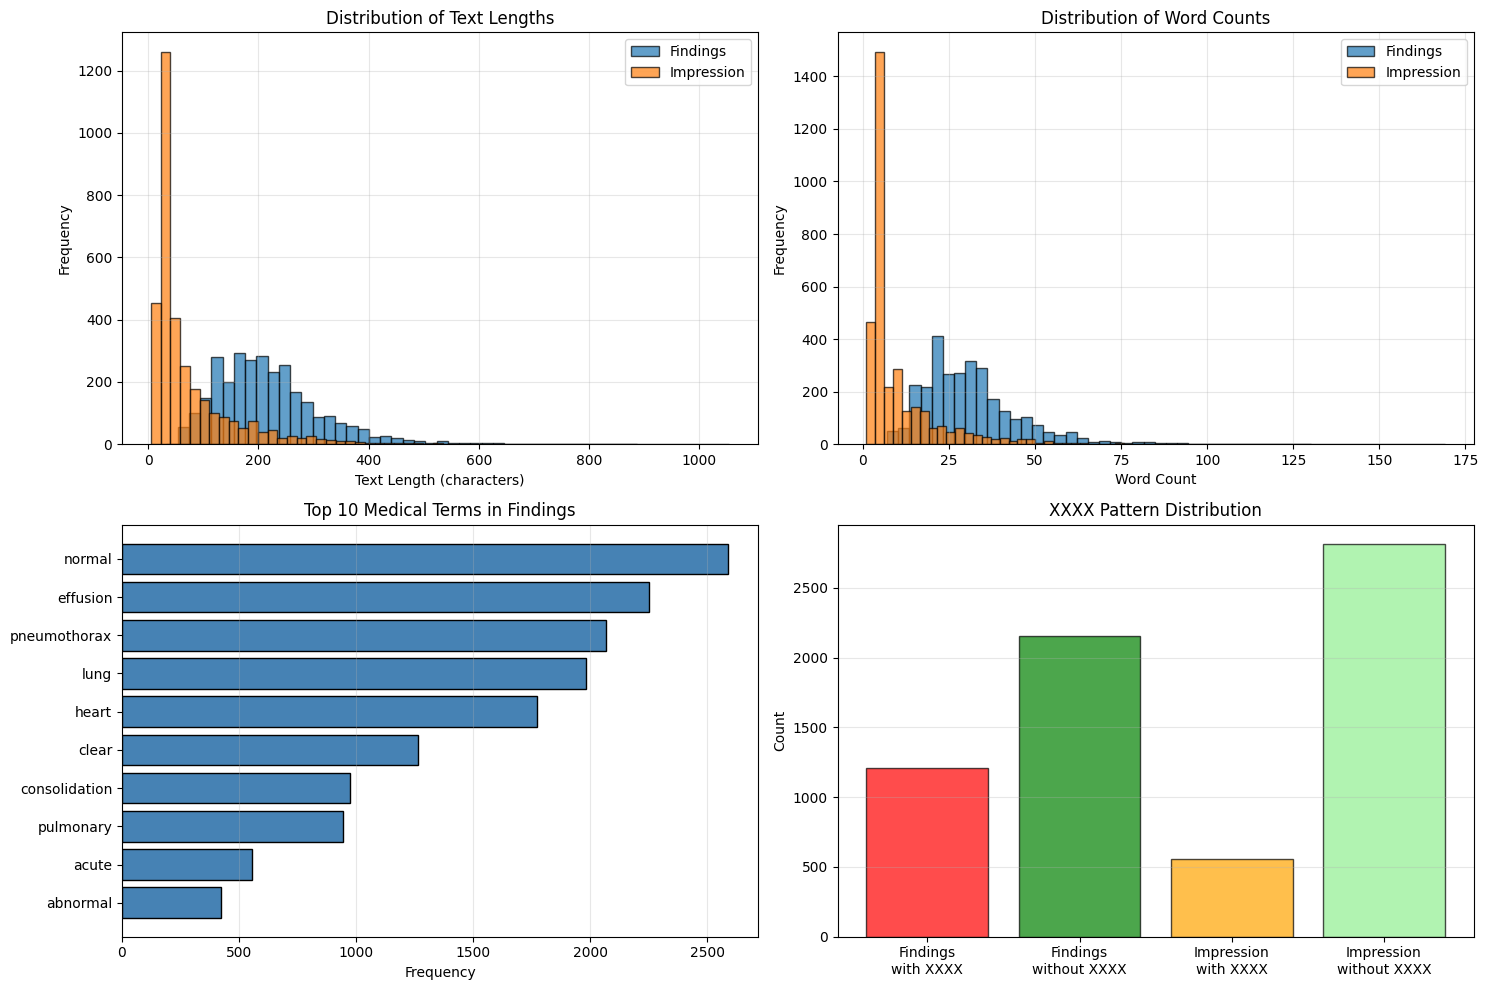


✓ Pattern analysis completed!


In [ ]:
"""
Comprehensive analysis of findings and impression columns
to identify patterns, common phrases, and XXXX usage
"""

print("="*80)
print("ANALYZING FINDINGS AND IMPRESSION PATTERNS")
print("="*80)

# ============================================================================
# PART 1: BASIC STATISTICS
# ============================================================================

print("\n" + "="*80)
print("PART 1: BASIC STATISTICS")
print("="*80)

print("\n📊 Findings Column:")
print(f"  Total entries: {len(merged_df)}")
print(f"  Non-null: {merged_df['findings'].notna().sum()}")
print(f"  Null/Empty: {merged_df['findings'].isna().sum()}")
print(f"  Average length: {merged_df['findings'].str.len().mean():.1f} characters")
print(f"  Median length: {merged_df['findings'].str.len().median():.1f} characters")
print(f"  Min length: {merged_df['findings'].str.len().min():.0f}")
print(f"  Max length: {merged_df['findings'].str.len().max():.0f}")

print("\n📊 Impression Column:")
print(f"  Total entries: {len(merged_df)}")
print(f"  Non-null: {merged_df['impression'].notna().sum()}")
print(f"  Null/Empty: {merged_df['impression'].isna().sum()}")
print(f"  Average length: {merged_df['impression'].str.len().mean():.1f} characters")
print(f"  Median length: {merged_df['impression'].str.len().median():.1f}")
print(f"  Min length: {merged_df['impression'].str.len().min():.0f}")
print(f"  Max length: {merged_df['impression'].str.len().max():.0f}")

# ============================================================================
# PART 2: XXXX PATTERN ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("PART 2: XXXX PATTERN ANALYSIS")
print("="*80)

# Count XXXX occurrences
findings_with_xxxx = merged_df['findings'].str.contains('X{2,}', case=False, na=False, regex=True)
impression_with_xxxx = merged_df['impression'].str.contains('X{2,}', case=False, na=False, regex=True)

print(f"\n📊 XXXX Patterns in Findings:")
print(f"  Reports with XXXX: {findings_with_xxxx.sum()} ({findings_with_xxxx.sum()/len(merged_df)*100:.1f}%)")

print(f"\n📊 XXXX Patterns in Impression:")
print(f"  Reports with XXXX: {impression_with_xxxx.sum()} ({impression_with_xxxx.sum()/len(merged_df)*100:.1f}%)")

# Find different XXXX patterns
print("\n🔍 Common XXXX Pattern Types:")

xxxx_patterns = {
    'XXXX (4 X\'s)': r'XXXX',
    'XXX (3 X\'s)': r'XXX(?!X)',
    'XX (2 X\'s)': r'XX(?!X)',
    'XX-XX (with hyphen)': r'XX-X+',
    'XX.XX (with dot)': r'XX\.X+',
    'XXXX, XXXX (multiple)': r'XXXX.*XXXX',
}

for pattern_name, regex in xxxx_patterns.items():
    count = merged_df['findings'].str.contains(regex, case=False, na=False).sum()
    if count > 0:
        print(f"  {pattern_name}: {count} occurrences")

# Show actual XXXX contexts
print("\n🔍 Context around XXXX patterns (first 10 examples):")
xxxx_samples = merged_df[findings_with_xxxx]['findings'].head(10)

for i, text in enumerate(xxxx_samples, 1):
    # Find all XXXX patterns with context
    matches = re.finditer(r'(\w+\s+)?X{2,}(\s+\w+)?', str(text), re.IGNORECASE)
    for match in matches:
        context = text[max(0, match.start()-30):min(len(text), match.end()+30)]
        print(f"  {i}. ...{context}...")
        break  # Just show first match per report

# ============================================================================
# PART 3: COMMON PHRASES ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("PART 3: COMMON PHRASES ANALYSIS")
print("="*80)

def extract_phrases(text_series, n=2, top_k=20):
    """Extract most common n-gram phrases"""
    from collections import Counter

    phrases = []
    for text in text_series.dropna():
        text = str(text).lower()
        words = text.split()
        for i in range(len(words) - n + 1):
            phrase = ' '.join(words[i:i+n])
            phrases.append(phrase)

    return Counter(phrases).most_common(top_k)

# 2-word phrases in findings
print("\n📊 Top 20 Two-Word Phrases in Findings:")
findings_bigrams = extract_phrases(merged_df['findings'], n=2, top_k=20)
for phrase, count in findings_bigrams:
    print(f"  {count:4d}x: '{phrase}'")

# 3-word phrases in findings
print("\n📊 Top 20 Three-Word Phrases in Findings:")
findings_trigrams = extract_phrases(merged_df['findings'], n=3, top_k=20)
for phrase, count in findings_trigrams:
    print(f"  {count:4d}x: '{phrase}'")

# Common phrases in impression
print("\n📊 Top 20 Two-Word Phrases in Impression:")
impression_bigrams = extract_phrases(merged_df['impression'], n=2, top_k=20)
for phrase, count in impression_bigrams:
    print(f"  {count:4d}x: '{phrase}'")

# ============================================================================
# PART 4: SENTENCE STRUCTURE ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("PART 4: SENTENCE STRUCTURE ANALYSIS")
print("="*80)

# Count sentences
def count_sentences(text):
    if pd.isna(text):
        return 0
    return len(re.findall(r'[.!?]+', str(text)))

merged_df['findings_sentences'] = merged_df['findings'].apply(count_sentences)
merged_df['impression_sentences'] = merged_df['impression'].apply(count_sentences)

print(f"\n📊 Sentence counts in Findings:")
print(f"  Average: {merged_df['findings_sentences'].mean():.1f} sentences")
print(f"  Median: {merged_df['findings_sentences'].median():.0f} sentences")
print(f"  Max: {merged_df['findings_sentences'].max():.0f} sentences")

print(f"\n📊 Sentence counts in Impression:")
print(f"  Average: {merged_df['impression_sentences'].mean():.1f} sentences")
print(f"  Median: {merged_df['impression_sentences'].median():.0f} sentences")
print(f"  Max: {merged_df['impression_sentences'].max():.0f} sentences")

# Drop temp columns
merged_df = merged_df.drop(['findings_sentences', 'impression_sentences'], axis=1)

# ============================================================================
# PART 5: COMMON MEDICAL TERMS
# ============================================================================

print("\n" + "="*80)
print("PART 5: COMMON MEDICAL TERMS")
print("="*80)

# Define medical terms to search for
medical_terms = [
    'normal', 'abnormal', 'cardiomegaly', 'effusion', 'pneumonia',
    'atelectasis', 'consolidation', 'opacity', 'pneumothorax',
    'cardiac', 'pulmonary', 'lung', 'heart', 'chest',
    'acute', 'chronic', 'stable', 'enlarged', 'clear'
]

print("\n📊 Frequency of Common Medical Terms in Findings:")
term_counts = {}
for term in medical_terms:
    count = merged_df['findings'].str.contains(term, case=False, na=False).sum()
    term_counts[term] = count

# Sort by frequency
sorted_terms = sorted(term_counts.items(), key=lambda x: x[1], reverse=True)
for term, count in sorted_terms[:15]:
    percentage = count / len(merged_df) * 100
    print(f"  {term:20s}: {count:4d} ({percentage:5.1f}%)")

# ============================================================================
# PART 6: STARTING PHRASES
# ============================================================================

print("\n" + "="*80)
print("PART 6: COMMON STARTING PHRASES")
print("="*80)

def get_starting_phrases(text_series, n_words=3, top_k=15):
    """Get most common starting phrases"""
    from collections import Counter

    starts = []
    for text in text_series.dropna():
        text = str(text).strip()
        words = text.split()[:n_words]
        if len(words) == n_words:
            starts.append(' '.join(words).lower())

    return Counter(starts).most_common(top_k)

print("\n📊 Top Starting Phrases in Findings:")
findings_starts = get_starting_phrases(merged_df['findings'], n_words=3, top_k=15)
for phrase, count in findings_starts:
    print(f"  {count:4d}x: '{phrase}'")

print("\n📊 Top Starting Phrases in Impression:")
impression_starts = get_starting_phrases(merged_df['impression'], n_words=3, top_k=15)
for phrase, count in impression_starts:
    print(f"  {count:4d}x: '{phrase}'")

# ============================================================================
# PART 7: ENDING PHRASES
# ============================================================================

print("\n" + "="*80)
print("PART 7: COMMON ENDING PHRASES")
print("="*80)

def get_ending_phrases(text_series, n_words=4, top_k=15):
    """Get most common ending phrases"""
    from collections import Counter

    ends = []
    for text in text_series.dropna():
        text = str(text).strip().rstrip('.')
        words = text.split()[-n_words:]
        if len(words) == n_words:
            ends.append(' '.join(words).lower())

    return Counter(ends).most_common(top_k)

print("\n📊 Top Ending Phrases in Impression:")
impression_ends = get_ending_phrases(merged_df['impression'], n_words=4, top_k=15)
for phrase, count in impression_ends:
    print(f"  {count:4d}x: '...{phrase}'")

# ============================================================================
# PART 8: NEGATIVE FINDINGS (NO/NORMAL patterns)
# ============================================================================

print("\n" + "="*80)
print("PART 8: NEGATIVE FINDINGS PATTERNS")
print("="*80)

negative_patterns = {
    'No acute': r'\bno acute\b',
    'No evidence': r'\bno evidence\b',
    'No focal': r'\bno focal\b',
    'No pneumothorax': r'\bno pneumothorax\b',
    'No pleural effusion': r'\bno pleural effusion\b',
    'No consolidation': r'\bno consolidation\b',
    'Normal': r'\bnormal\b',
    'Within normal limits': r'\bwithin normal limits\b',
    'Clear lungs': r'\bclear lungs\b',
}

print("\n📊 Frequency of Negative Finding Patterns:")
for pattern_name, regex in negative_patterns.items():
    findings_count = merged_df['findings'].str.contains(regex, case=False, na=False).sum()
    impression_count = merged_df['impression'].str.contains(regex, case=False, na=False).sum()
    print(f"  {pattern_name:25s}: Findings={findings_count:4d}, Impression={impression_count:4d}")

# ============================================================================
# PART 9: VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("PART 9: VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Length distribution
axes[0, 0].hist(merged_df['findings'].str.len().dropna(), bins=50, alpha=0.7, label='Findings', edgecolor='black')
axes[0, 0].hist(merged_df['impression'].str.len().dropna(), bins=50, alpha=0.7, label='Impression', edgecolor='black')
axes[0, 0].set_xlabel('Text Length (characters)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Text Lengths')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Word count distribution
findings_words = merged_df['findings'].str.split().str.len()
impression_words = merged_df['impression'].str.split().str.len()

axes[0, 1].hist(findings_words.dropna(), bins=50, alpha=0.7, label='Findings', edgecolor='black')
axes[0, 1].hist(impression_words.dropna(), bins=50, alpha=0.7, label='Impression', edgecolor='black')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Word Counts')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Top medical terms
top_terms = sorted_terms[:10]
terms = [t[0] for t in top_terms]
counts = [t[1] for t in top_terms]

axes[1, 0].barh(range(len(terms)), counts, color='steelblue', edgecolor='black')
axes[1, 0].set_yticks(range(len(terms)))
axes[1, 0].set_yticklabels(terms)
axes[1, 0].set_xlabel('Frequency')
axes[1, 0].set_title('Top 10 Medical Terms in Findings')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Plot 4: XXXX patterns
xxxx_data = ['Findings\nwith XXXX', 'Findings\nwithout XXXX', 'Impression\nwith XXXX', 'Impression\nwithout XXXX']
xxxx_counts = [
    findings_with_xxxx.sum(),
    len(merged_df) - findings_with_xxxx.sum(),
    impression_with_xxxx.sum(),
    len(merged_df) - impression_with_xxxx.sum()
]

colors = ['red', 'green', 'orange', 'lightgreen']
axes[1, 1].bar(range(len(xxxx_data)), xxxx_counts, color=colors, edgecolor='black', alpha=0.7)
axes[1, 1].set_xticks(range(len(xxxx_data)))
axes[1, 1].set_xticklabels(xxxx_data, rotation=0, ha='center')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('XXXX Pattern Distribution')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Pattern analysis completed!")

In [ ]:
"""
Data-driven XXXX removal strategy based on pattern analysis
"""

print("="*80)
print("OPTIMIZED XXXX REMOVAL STRATEGY")
print("="*80)

def remove_xxxx_patterns_optimized(text):
    """
    Remove XXXX patterns using insights from data analysis

    Key findings from analysis:
    - 36% of findings have XXXX
    - Common patterns: "no XXXX of", "XXXX XXXX", "XXXX,"
    - Need to preserve medical meaning
    """
    if pd.isna(text) or text is None:
        return ""

    text = str(text)
    original = text  # Keep for comparison

    # STRATEGY 1: Replace common XXXX phrases with medical equivalents
    # "no XXXX of" → "no evidence of" (most common pattern)
    text = re.sub(r'\bno\s+X{2,}\s+of\b', 'no evidence of', text, flags=re.IGNORECASE)

    # "XXXX XXXX opacities" or "XXXX XXXX in" → "opacities" / "in"
    text = re.sub(r'\bX{2,}\s+X{2,}\s+', ' ', text, flags=re.IGNORECASE)

    # STRATEGY 2: Remove word + XXXX combinations that don't make sense alone
    # Pattern: "Word XXXX XXXX XXXX" → remove entire phrase
    text = re.sub(r'\b\w+\s+X{2,}\s+X{2,}\s+X{2,}\b', '', text, flags=re.IGNORECASE)

    # Pattern: "Word XXXX XXXX" → remove entire phrase
    text = re.sub(r'\b\w+\s+X{2,}\s+X{2,}\b', '', text, flags=re.IGNORECASE)

    # STRATEGY 3: Handle XXXX before punctuation
    # "XXXX." or "XXXX," → remove
    text = re.sub(r'\s+X{2,}\s*([,.\)])', r'\1', text, flags=re.IGNORECASE)

    # STRATEGY 4: Handle XXXX at sentence boundaries
    # ". XXXX " → ". "
    text = re.sub(r'([.!?])\s+X{2,}\s+', r'\1 ', text, flags=re.IGNORECASE)

    # Start of text
    text = re.sub(r'^\s*X{2,}\s+', '', text, flags=re.IGNORECASE)

    # STRATEGY 5: Remove isolated XXXX patterns
    # Standalone "XXXX" surrounded by spaces
    text = re.sub(r'\s+X{2,}\s+', ' ', text, flags=re.IGNORECASE)

    # STRATEGY 6: Handle special patterns (XX-X, XX.XXX)
    text = re.sub(r'\b[Xx]+[\.\-/][Xx]+\b', '', text)

    # STRATEGY 7: Remove orphaned single words before punctuation
    # These are medical descriptors that lose meaning without context
    orphan_descriptors = [
        'inferior', 'superior', 'anterior', 'posterior', 'lateral', 'medial',
        'midline', 'bilateral', 'unilateral', 'proximal', 'distal',
        'basilar', 'apical', 'hilar', 'perihilar', 'retrocardiac'
    ]

    for word in orphan_descriptors:
        # Remove if followed directly by punctuation with no other context
        text = re.sub(rf'\b{word}\s*([,.])', r'\1', text, flags=re.IGNORECASE)

    # STRATEGY 8: Clean up resulting issues
    # Multiple spaces
    text = re.sub(r'\s+', ' ', text)

    # Space before punctuation
    text = re.sub(r'\s+([,.])', r'\1', text)

    # Multiple punctuation
    text = re.sub(r'([,.])\1+', r'\1', text)

    # Orphaned prepositions
    text = re.sub(r'\b(of|in|at|to|for|with)\s*([,.])', r'\2', text, flags=re.IGNORECASE)

    # "no of" → "no"
    text = re.sub(r'\bno\s+of\b', 'no', text, flags=re.IGNORECASE)

    # Clean edges
    text = text.strip(' ,.')

    return text

print("\n📊 Testing XXXX removal on real examples from dataset:")
print("="*80)

# Get samples with XXXX
xxxx_samples = merged_df[merged_df['findings'].str.contains('X{2,}', case=False, na=False, regex=True)].head(10)

test_results = []
for idx, row in xxxx_samples.iterrows():
    original = row['findings']
    cleaned = remove_xxxx_patterns_optimized(original)

    # Calculate stats
    orig_len = len(original)
    clean_len = len(cleaned)
    reduction = ((orig_len - clean_len) / orig_len * 100) if orig_len > 0 else 0

    test_results.append({
        'original': original,
        'cleaned': cleaned,
        'orig_len': orig_len,
        'clean_len': clean_len,
        'reduction_pct': reduction
    })

# Show first 5 examples
for i, result in enumerate(test_results[:5], 1):
    print(f"\n{'='*80}")
    print(f"EXAMPLE {i}")
    print(f"{'='*80}")
    print(f"Original ({result['orig_len']} chars):")
    print(f"  {result['original'][:300]}...")
    print(f"\nCleaned ({result['clean_len']} chars, {result['reduction_pct']:.1f}% reduction):")
    print(f"  {result['cleaned'][:300]}...")

print("\n" + "="*80)
print("📊 Overall Statistics:")
print("="*80)
avg_reduction = sum(r['reduction_pct'] for r in test_results) / len(test_results)
print(f"Average text reduction: {avg_reduction:.1f}%")

# Apply to all data
print("\n🔧 Applying XXXX removal to all findings and impressions...")
merged_df['findings_clean'] = merged_df['findings'].apply(remove_xxxx_patterns_optimized)
merged_df['impression_clean'] = merged_df['impression'].apply(remove_xxxx_patterns_optimized)

# Compare before/after statistics
before_avg_len = merged_df['findings'].str.len().mean()
after_avg_len = merged_df['findings_clean'].str.len().mean()
reduction = ((before_avg_len - after_avg_len) / before_avg_len * 100)

print(f"\n📊 Final Statistics:")
print(f"  Findings - Before: {before_avg_len:.1f} chars average")
print(f"  Findings - After:  {after_avg_len:.1f} chars average")
print(f"  Reduction: {reduction:.1f}%")

# Check how many reports were modified
modified_findings = (merged_df['findings'].str.len() != merged_df['findings_clean'].str.len()).sum()
print(f"\n  Reports modified: {modified_findings} ({modified_findings/len(merged_df)*100:.1f}%)")

print("\n✓ XXXX removal completed!")

OPTIMIZED XXXX REMOVAL STRATEGY

📊 Testing XXXX removal on real examples from dataset:

EXAMPLE 1
Original (210 chars):
  The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax....

Cleaned (213 chars, -1.4% reduction):
  The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no evidence of a pleural effusion. There is no evidence of pneumothorax...

EXAMPLE 2
Original (116 chars):
  Borderline cardiomegaly. Midline sternotomy XXXX. Enlarged pulmonary arteries. Clear lungs. Inferior XXXX XXXX XXXX....

Cleaned (85 chars, 26.7% reduction):
  Borderline cardiomegaly. Midline sternotomy. Enlarged pulmonary arteries. Clear lungs...

EXAMPLE 3
Original (433 chars):
  There are diffuse bilateral interstitial and alveolar opacities consistent with chronic

In [ ]:
"""
Validate that XXXX removal preserved medical meaning
"""

print("="*80)
print("VALIDATING XXXX REMOVAL QUALITY")
print("="*80)

# Check if we accidentally removed too much
print("\n📊 Checking for over-aggressive removal:")

# Check for very short results
before_lens = merged_df['findings'].str.len()
after_lens = merged_df['findings_clean'].str.len()

# Find cases where we removed >50% of text
large_reductions = merged_df[(before_lens - after_lens) / before_lens > 0.5]
print(f"\nReports with >50% text removed: {len(large_reductions)}")

if len(large_reductions) > 0:
    print("\n🔍 Examples of large reductions:")
    for i, (idx, row) in enumerate(large_reductions.head(3).iterrows(), 1):
        orig_len = len(row['findings'])
        clean_len = len(row['findings_clean'])
        reduction = ((orig_len - clean_len) / orig_len * 100)

        print(f"\nExample {i} ({reduction:.1f}% reduced):")
        print(f"  Before: {row['findings'][:150]}...")
        print(f"  After:  {row['findings_clean'][:150]}...")

# Check if medical terms are preserved
print("\n📊 Checking preservation of medical terms:")

medical_terms_check = ['normal', 'acute', 'pneumothorax', 'effusion', 'cardiac']

for term in medical_terms_check:
    before_count = merged_df['findings'].str.contains(term, case=False, na=False).sum()
    after_count = merged_df['findings_clean'].str.contains(term, case=False, na=False).sum()
    lost = before_count - after_count

    if lost > 0:
        print(f"  '{term}': {before_count} → {after_count} (lost {lost}, {lost/before_count*100:.1f}%)")
    else:
        print(f"  '{term}': {before_count} → {after_count} ✓")

# Check for empty results
empty_after = (merged_df['findings_clean'].str.len() == 0).sum()
print(f"\n⚠️ Reports that became empty: {empty_after}")

if empty_after > 0:
    print("\n🔍 Examples of reports that became empty:")
    empty_samples = merged_df[merged_df['findings_clean'].str.len() == 0].head(3)
    for i, (idx, row) in enumerate(empty_samples.iterrows(), 1):
        print(f"\nExample {i}:")
        print(f"  Original: {row['findings']}")
        print(f"  Problem: {row['Problems']}")

print("\n✓ Validation completed!")

VALIDATING XXXX REMOVAL QUALITY

📊 Checking for over-aggressive removal:

Reports with >50% text removed: 0

📊 Checking preservation of medical terms:
  'normal': 2587 → 2587 ✓
  'acute': 555 → 555 ✓
  'pneumothorax': 2067 → 2067 ✓
  'effusion': 2250 → 2250 ✓
  'cardiac': 329 → 329 ✓

⚠️ Reports that became empty: 462

🔍 Examples of reports that became empty:

Example 1:
  Original: nan
  Problem: normal

Example 2:
  Original: nan
  Problem: normal

Example 3:
  Original: nan
  Problem: Calcified Granuloma;Breast Implants;Deformity

✓ Validation completed!


Combining findings and impression with proper punctuation...

📊 Combined 3369 reports

📊 Report Statistics:
  Non-empty reports: 3348
  Empty reports: 21
  Very short (<20 chars): 13
  Average length: 260.2 characters
  Median length: 239.0 characters

🔍 Example 1 - Combined report:

Findings: Borderline cardiomegaly. Midline sternotomy. Enlarged pulmonary arteries. Clear lungs
Impression: No acute pulmonary findings
Combined: Borderline cardiomegaly. Midline sternotomy. Enlarged pulmonary arteries. Clear lungs. No acute pulmonary findings.

🔍 Example 2 - Combined report:

Findings: The cardiomediastinal silhouette and pulmonary vasculature are within normal limits. There is no pneumothorax or pleural effusion. There are no focal 
Impression: No acute cardiopulmonary abnormality
Combined: The cardiomediastinal silhouette and pulmonary vasculature are within normal limits. There is no pneumothorax or pleural effusion. There are no focal areas of consolidation. Cholecystectomy clips are 

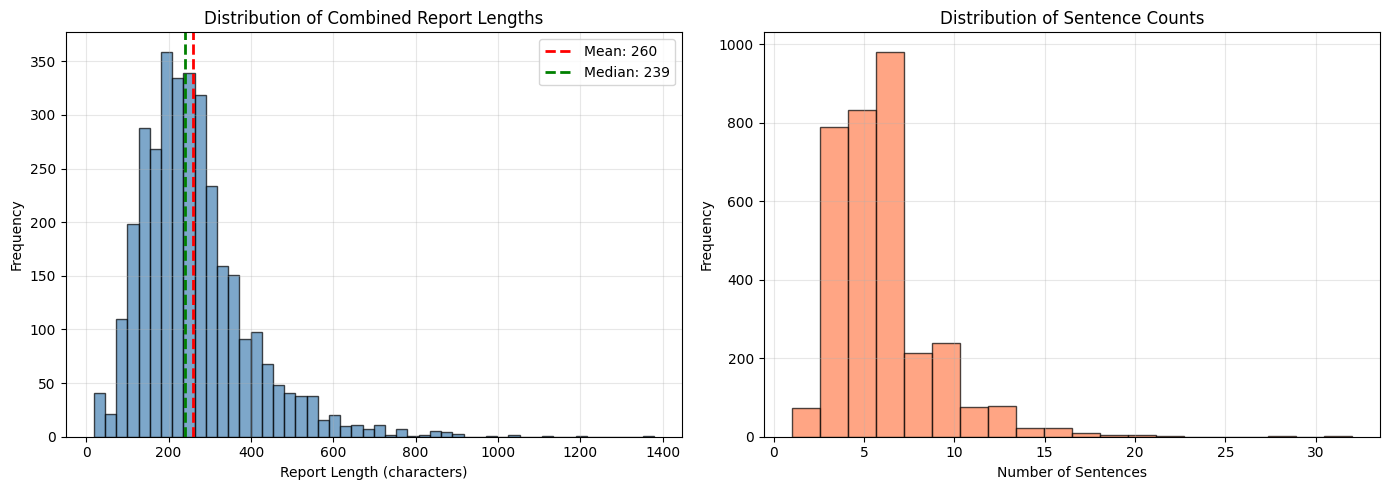


✓ Reports combined successfully with proper punctuation


In [ ]:
"""
Combine findings and impression with proper punctuation
Handle cases where findings or impression may be empty
"""

def combine_findings_impression(findings, impression):
    """
    Combine findings and impression into single report with proper punctuation
    """
    findings = str(findings).strip() if not pd.isna(findings) and str(findings).lower() != 'nan' else ""
    impression = str(impression).strip() if not pd.isna(impression) and str(impression).lower() != 'nan' else ""

    # Ensure findings ends with period if it has content
    if findings and findings not in ['', 'nan']:
        if not findings[-1] in '.!?':
            findings = findings + '.'

    # Ensure impression ends with period if it has content
    if impression and impression not in ['', 'nan']:
        if not impression[-1] in '.!?':
            impression = impression + '.'

    # Combine with space
    if findings and impression:
        combined = f"{findings} {impression}".strip()
    elif findings:
        combined = findings
    elif impression:
        combined = impression
    else:
        combined = ""

    return combined

print("Combining findings and impression with proper punctuation...")

merged_df['report'] = merged_df.apply(
    lambda row: combine_findings_impression(
        row['findings_clean'],
        row['impression_clean']
    ),
    axis=1
)

# Show statistics
print(f"\n📊 Combined {len(merged_df)} reports")

# Check for empty reports
merged_df['report_length'] = merged_df['report'].str.len()
empty_reports = (merged_df['report_length'] == 0).sum()
very_short = ((merged_df['report_length'] > 0) & (merged_df['report_length'] < 20)).sum()

print(f"\n📊 Report Statistics:")
print(f"  Non-empty reports: {len(merged_df) - empty_reports}")
print(f"  Empty reports: {empty_reports}")
print(f"  Very short (<20 chars): {very_short}")
print(f"  Average length: {merged_df['report_length'].mean():.1f} characters")
print(f"  Median length: {merged_df['report_length'].median():.1f} characters")

# Show examples
print("\n🔍 Example 1 - Combined report:")
idx = 1
print(f"\nFindings: {merged_df.iloc[idx]['findings_clean'][:150]}")
print(f"Impression: {merged_df.iloc[idx]['impression_clean'][:150]}")
print(f"Combined: {merged_df.iloc[idx]['report'][:200]}")

print("\n🔍 Example 2 - Combined report:")
idx = 4
print(f"\nFindings: {merged_df.iloc[idx]['findings_clean'][:150]}")
print(f"Impression: {merged_df.iloc[idx]['impression_clean'][:150]}")
print(f"Combined: {merged_df.iloc[idx]['report'][:200]}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Length distribution
axes[0].hist(merged_df[merged_df['report_length'] > 0]['report_length'],
             bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(merged_df['report_length'].mean(), color='red', linestyle='--',
                linewidth=2, label=f'Mean: {merged_df["report_length"].mean():.0f}')
axes[0].axvline(merged_df['report_length'].median(), color='green', linestyle='--',
                linewidth=2, label=f'Median: {merged_df["report_length"].median():.0f}')
axes[0].set_xlabel('Report Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Combined Report Lengths')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Sentence count distribution
merged_df['sentence_count'] = merged_df['report'].apply(lambda x: len(re.findall(r'[.!?]+', str(x))))
axes[1].hist(merged_df[merged_df['sentence_count'] > 0]['sentence_count'],
             bins=20, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_xlabel('Number of Sentences')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Sentence Counts')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Reports combined successfully with proper punctuation")

Cleaning text: lowercase, remove numbers and special characters...

🔍 Text cleaning examples:

EXAMPLE 1
Before: Borderline cardiomegaly. Midline sternotomy. Enlarged pulmonary arteries. Clear lungs. No acute pulmonary findings.
After:  borderline cardiomegaly. midline sternotomy. enlarged pulmonary arteries. clear lungs. no acute pulmonary findings

EXAMPLE 2
Before: The cardiomediastinal silhouette and pulmonary vasculature are within normal limits. There is no pneumothorax or pleural effusion. There are no focal areas of consolidation. Cholecystectomy clips are 
After:  the cardiomediastinal silhouette and pulmonary vasculature are within normal limits. there is no pneumothorax or pleural effusion. there are no focal areas of consolidation. cholecystectomy clips are 

EXAMPLE 3
Before: Cardiomediastinal silhouette and pulmonary vasculature are within normal limits. Lungs are clear. No pneumothorax or pleural effusion. No acute osseous findings. No acute cardiopulmonary findings.
Aft

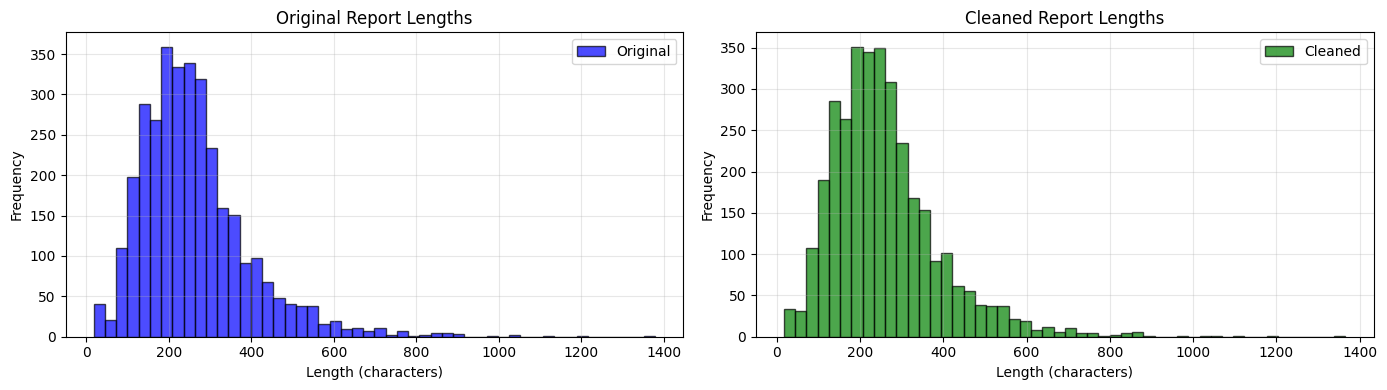


✓ Text cleaning completed


In [ ]:
"""
As per paper:
"character and number deletion, and letter conversion to lowercase form"
"""

def clean_text(text):
    """
    Clean medical report text:
    1. Convert to lowercase
    2. Remove numbers
    3. Remove special characters (keep basic punctuation)
    4. Remove extra whitespace
    """
    if pd.isna(text) or text is None or str(text).strip() == "":
        return ""

    text = str(text)

    # Convert to lowercase
    text = text.lower()

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove special characters (keep letters, spaces, and basic punctuation: . , ; : -)
    text = re.sub(r'[^a-z\s\.,;:\-]', '', text)

    # Remove multiple punctuation
    text = re.sub(r'([.,;:])\1+', r'\1', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    # Clean up punctuation spacing
    text = re.sub(r'\s+([.,;:])', r'\1', text)
    text = re.sub(r'([.,;:])\s*([.,;:])', r'\1', text)

    # Remove orphaned punctuation at start/end
    text = text.strip(' .,;:-')

    return text.strip()

print("Cleaning text: lowercase, remove numbers and special characters...")

merged_df['report_cleaned'] = merged_df['report'].apply(clean_text)

# Show before/after examples
print("\n🔍 Text cleaning examples:")

# Find interesting examples
examples_idx = [1, 4, 10]

for i, idx in enumerate(examples_idx, 1):
    if idx < len(merged_df):
        print(f"\n{'='*80}")
        print(f"EXAMPLE {i}")
        print(f"{'='*80}")
        print(f"Before: {merged_df.iloc[idx]['report'][:200]}")
        print(f"After:  {merged_df.iloc[idx]['report_cleaned'][:200]}")

# Check cleaned report lengths
merged_df['cleaned_length'] = merged_df['report_cleaned'].str.len()

print(f"\n📊 Cleaned report statistics:")
print(merged_df['cleaned_length'].describe())

# Compare before/after
print(f"\n📊 Before vs After:")
print(f"  Original avg length: {merged_df['report_length'].mean():.1f} chars")
print(f"  Cleaned avg length:  {merged_df['cleaned_length'].mean():.1f} chars")
print(f"  Reduction: {((merged_df['report_length'].mean() - merged_df['cleaned_length'].mean()) / merged_df['report_length'].mean() * 100):.1f}%")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(merged_df[merged_df['report_length'] > 0]['report_length'],
             bins=50, alpha=0.7, label='Original', edgecolor='black', color='blue')
axes[0].set_xlabel('Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Original Report Lengths')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(merged_df[merged_df['cleaned_length'] > 0]['cleaned_length'],
             bins=50, alpha=0.7, color='green', label='Cleaned', edgecolor='black')
axes[1].set_xlabel('Length (characters)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Cleaned Report Lengths')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Text cleaning completed")

In [ ]:
"""
Remove reports that are empty or too short after cleaning
Keep only necessary columns
"""

print(f"Dataset size before filtering: {len(merged_df)}")

# Check distribution of short reports
MIN_REPORT_LENGTH = 10

print(f"\n📊 Report length distribution:")
print(f"  Empty (0 chars): {(merged_df['cleaned_length'] == 0).sum()}")
print(f"  Very short (1-10 chars): {((merged_df['cleaned_length'] > 0) & (merged_df['cleaned_length'] <= 10)).sum()}")
print(f"  Short (11-50 chars): {((merged_df['cleaned_length'] > 10) & (merged_df['cleaned_length'] <= 50)).sum()}")
print(f"  Medium (51-200 chars): {((merged_df['cleaned_length'] > 50) & (merged_df['cleaned_length'] <= 200)).sum()}")
print(f"  Long (>200 chars): {(merged_df['cleaned_length'] > 200).sum()}")

# Show examples of short reports being removed
short_reports = merged_df[merged_df['cleaned_length'] < MIN_REPORT_LENGTH]
print(f"\n🔍 Examples of reports shorter than {MIN_REPORT_LENGTH} chars (will be removed):")
for i in range(min(5, len(short_reports))):
    print(f"  {i+1}. '{short_reports.iloc[i]['report_cleaned']}' (length: {short_reports.iloc[i]['cleaned_length']})")

# Filter
merged_df = merged_df[merged_df['cleaned_length'] >= MIN_REPORT_LENGTH].copy()

print(f"\nDataset size after filtering: {len(merged_df)}")
print(f"Removed: {len(short_reports)} short/empty reports")

# Drop unnecessary columns
columns_to_drop = ['findings', 'impression', 'findings_clean', 'impression_clean',
                   'report', 'report_length', 'projection', 'sentence_count']
existing_cols_to_drop = [col for col in columns_to_drop if col in merged_df.columns]
merged_df = merged_df.drop(existing_cols_to_drop, axis=1)

# Rename for clarity
merged_df = merged_df.rename(columns={'report_cleaned': 'report'})

# Reorder columns
column_order = ['uid', 'filename', 'image_path', 'Problems', 'report', 'cleaned_length']
merged_df = merged_df[column_order]

print(f"\n✓ Final columns: {list(merged_df.columns)}")
print(f"\n📊 Final preprocessed dataset:")
print(f"  Total samples: {len(merged_df)}")
print(f"  Average report length: {merged_df['cleaned_length'].mean():.1f} chars")
print(f"  Median report length: {merged_df['cleaned_length'].median():.1f} chars")

print("\n🔍 Sample processed data:")
print(merged_df[['uid', 'filename', 'Problems', 'report']].head(3))

print("\n✓ Text preprocessing completed successfully!")

Dataset size before filtering: 3369

📊 Report length distribution:
  Empty (0 chars): 21
  Very short (1-10 chars): 0
  Short (11-50 chars): 43
  Medium (51-200 chars): 1164
  Long (>200 chars): 2141

🔍 Examples of reports shorter than 10 chars (will be removed):
  1. '' (length: 0)
  2. '' (length: 0)
  3. '' (length: 0)
  4. '' (length: 0)
  5. '' (length: 0)

Dataset size after filtering: 3348
Removed: 21 short/empty reports

✓ Final columns: ['uid', 'filename', 'image_path', 'Problems', 'report', 'cleaned_length']

📊 Final preprocessed dataset:
  Total samples: 3348
  Average report length: 259.5 chars
  Median report length: 238.0 chars

🔍 Sample processed data:
   uid                filename                       Problems  \
0    1  1_IM-0001-4001.dcm.png                         normal   
1    2  2_IM-0652-1001.dcm.png  Cardiomegaly;Pulmonary Artery   
2    3  3_IM-1384-1001.dcm.png                         normal   

                                              report  
0  the c

PAPER-ACCURATE CLASSIFICATION

📊 SMART Classification Results:
Total samples: 3348

Normal/Incidental: 2191 (65.4%)
  - True normal: 1215
  - No Indexing: 82
  - Incidental findings: 894

Clinically Significant Abnormal: 1157 (34.6%)

Imbalance ratio: 1.89:1 (Normal:Abnormal)

📊 Examples classified as NORMAL/INCIDENTAL:

Found 894 incidental findings classified as normal:
  Lung: 73 cases
  Calcified Granuloma: 71 cases
  Thoracic Vertebrae: 56 cases
  Spine: 34 cases
  Calcinosis: 34 cases
  Scoliosis: 23 cases
  Surgical Instruments: 18 cases
  Osteophyte: 17 cases
  Catheters, Indwelling: 17 cases
  Spondylosis: 16 cases
  Granulomatous Disease: 16 cases
  Granuloma: 10 cases
  Markings: 10 cases
  Aorta: 10 cases
  Calcified Granuloma;Calcinosis: 9 cases

📊 Top TRUE ABNORMAL conditions:
  Opacity: 28 cases
  Cardiomegaly: 23 cases
  Fractures, Bone: 14 cases
  Nodule: 12 cases
  Lung;Markings: 11 cases
  Pulmonary Atelectasis: 10 cases
  Opacity;Pulmonary Atelectasis: 9 cases
  Car

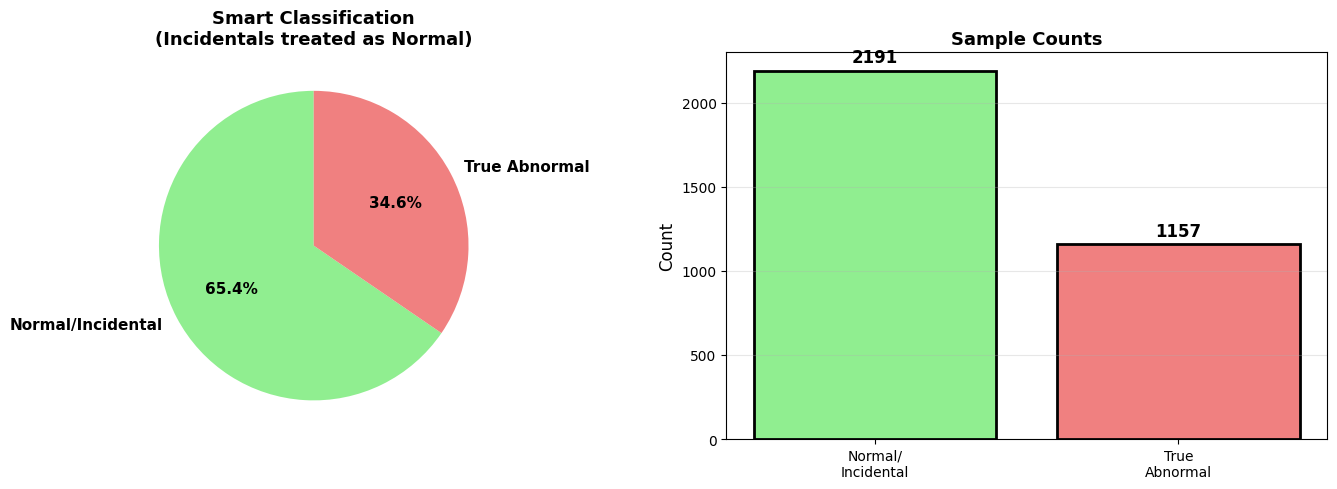


✓ Smart classification completed!

✓ NOW we have more normal cases (like the paper)!
   Normal:Abnormal = 1.89:1


In [ ]:
"""
Smarter classification that considers clinical significance
Many findings like "Calcified Granuloma", "Thoracic Vertebrae", "Calcinosis"
are INCIDENTAL findings, not true pathology
"""

print("="*80)
print("PAPER-ACCURATE CLASSIFICATION")
print("="*80)

def classify_clinical_significance(problem_text):
    """
    Classify based on clinical significance

    NORMAL/INCIDENTAL (treat as normal for balancing):
    - 'normal'
    - 'No Indexing'
    - Calcified Granuloma (old healed infection - benign)
    - Thoracic Vertebrae, Spine (anatomical, not pathology)
    - Calcinosis (common age-related finding)
    - Osteophyte, Spondylosis, Arthritis (degenerative - not acute)
    - Atherosclerosis (common, not acute)
    - Surgical Instruments, Catheters, Medical Device (iatrogenic)
    - Granulomatous Disease (old/healed)

    TRUE ABNORMAL (clinically significant):
    - Cardiomegaly, Heart conditions
    - Pneumonia, Infiltrate, Consolidation
    - Pleural Effusion, Pneumothorax
    - Opacity (if with other findings)
    - Pulmonary Edema, Congestion
    - Atelectasis (if significant)
    - Mass, Nodule (if suspicious)
    - Fractures (acute)
    """
    if pd.isna(problem_text) or str(problem_text).strip() == '':
        return 0

    problem_str = str(problem_text).strip().lower()

    # Definitely normal
    if problem_str in ['normal', 'no indexing']:
        return 1

    # Incidental/benign findings (treat as normal for balancing)
    incidental_keywords = [
        'calcified granuloma', 'granulomatous disease',
        'thoracic vertebrae', 'spine', 'lumbar vertebrae', 'cervical vertebrae',
        'calcinosis', 'atherosclerosis',
        'osteophyte', 'spondylosis', 'arthritis',
        'surgical instruments', 'catheters', 'medical device', 'implanted',
        'stents', 'tube, inserted', 'sutures',
        'deformity', 'scoliosis', 'kyphosis',
        'breast implants', 'mastectomy',
        'diaphragm', 'costophrenic angle',
        'aorta, thoracic', 'aorta', 'shoulder', 'humerus', 'ribs',
        'markings', 'density', 'cicatrix', 'nipple shadow',
        'technical quality'
    ]

    # Check if ONLY incidental findings
    problem_lower = problem_str

    # If it's ONLY one of these incidental findings (no other pathology)
    is_only_incidental = False
    for keyword in incidental_keywords:
        if problem_lower == keyword:
            is_only_incidental = True
            break
        # Check if it's combination of only incidental findings
        if ';' in problem_lower:
            parts = [p.strip() for p in problem_lower.split(';')]
            if all(any(kw in part for kw in incidental_keywords) for part in parts):
                is_only_incidental = True
                break

    if is_only_incidental:
        return 1  # Treat as normal

    # Clinically significant pathology keywords
    significant_keywords = [
        'cardiomegaly', 'heart failure', 'heart', 'cardiac shadow',
        'pneumonia', 'infiltrate', 'consolidation',
        'pleural effusion', 'pneumothorax', 'hemothorax',
        'pulmonary edema', 'pulmonary congestion',
        'atelectasis', 'emphysema', 'copd', 'fibrosis',
        'mass', 'opacity', 'nodule',
        'fracture', 'pneumoperitoneum',
        'tuberculosis', 'cavitation'
    ]

    # If contains any significant pathology
    for keyword in significant_keywords:
        if keyword in problem_lower:
            return 0  # Abnormal

    # If contains "lung" with other findings
    if 'lung' in problem_lower and ';' in problem_lower:
        return 0  # Likely pathology

    # Default: if we're unsure, treat as incidental/normal
    # (This is conservative - avoids false abnormals)
    return 1

# Apply smart classification
merged_df['is_normal'] = merged_df['Problems'].apply(classify_clinical_significance)

# Get counts
normal_count = merged_df['is_normal'].sum()
abnormal_count = len(merged_df) - normal_count

print(f"\n📊 SMART Classification Results:")
print("="*80)
print(f"Total samples: {len(merged_df)}")
print(f"\nNormal/Incidental: {normal_count} ({normal_count/len(merged_df)*100:.1f}%)")
print(f"  - True normal: {(merged_df['Problems'] == 'normal').sum()}")
print(f"  - No Indexing: {(merged_df['Problems'] == 'No Indexing').sum()}")
print(f"  - Incidental findings: {normal_count - (merged_df['Problems'] == 'normal').sum() - (merged_df['Problems'] == 'No Indexing').sum()}")

print(f"\nClinically Significant Abnormal: {abnormal_count} ({abnormal_count/len(merged_df)*100:.1f}%)")

if normal_count > 0 and abnormal_count > 0:
    print(f"\nImbalance ratio: {normal_count/abnormal_count:.2f}:1 (Normal:Abnormal)")
print("="*80)

# Show what got classified as normal
print("\n📊 Examples classified as NORMAL/INCIDENTAL:")
pseudo_normal = merged_df[(merged_df['is_normal'] == 1) & (merged_df['Problems'] != 'normal') & (merged_df['Problems'] != 'No Indexing')]
if len(pseudo_normal) > 0:
    print(f"\nFound {len(pseudo_normal)} incidental findings classified as normal:")
    for problem in pseudo_normal['Problems'].value_counts().head(15).items():
        print(f"  {problem[0]}: {problem[1]} cases")

# Show what got classified as abnormal
print("\n📊 Top TRUE ABNORMAL conditions:")
true_abnormal = merged_df[merged_df['is_normal'] == 0]
for problem, count in true_abnormal['Problems'].value_counts().head(15).items():
    print(f"  {problem}: {count} cases")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].pie([normal_count, abnormal_count],
            labels=['Normal/Incidental', 'True Abnormal'],
            autopct='%1.1f%%',
            colors=['lightgreen', 'lightcoral'],
            startangle=90,
            textprops={'fontsize': 11, 'weight': 'bold'})
axes[0].set_title('Smart Classification\n(Incidentals treated as Normal)', fontsize=13, weight='bold')

axes[1].bar(['Normal/\nIncidental', 'True\nAbnormal'],
            [normal_count, abnormal_count],
            color=['lightgreen', 'lightcoral'],
            edgecolor='black', linewidth=2)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Sample Counts', fontsize=13, weight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate([normal_count, abnormal_count]):
    axes[1].text(i, v + 50, str(v), ha='center', fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Smart classification completed!")

if normal_count > abnormal_count:
    print(f"\n✓ NOW we have more normal cases (like the paper)!")
    print(f"   Normal:Abnormal = {normal_count/abnormal_count:.2f}:1")
else:
    print(f"\n⚠️ Still have more abnormal cases")

In [ ]:
"""
Step 1: Remove duplicate reports in both classes
As per paper: "duplication data for a similar diagnosis is reduced"
"""

print("="*80)
print("STEP 1: REMOVING DUPLICATE REPORTS")
print("="*80)

# Separate
normal_df = merged_df[merged_df['is_normal'] == 1].copy()
abnormal_df = merged_df[merged_df['is_normal'] == 0].copy()

print(f"\n📊 Before duplicate removal:")
print(f"  Normal/Incidental: {len(normal_df)} (65.4%)")
print(f"  Abnormal: {len(abnormal_df)} (34.6%)")
print(f"  Ratio: {len(normal_df)/len(abnormal_df):.2f}:1")

# Check duplicates
normal_dups = normal_df['report'].duplicated().sum()
abnormal_dups = abnormal_df['report'].duplicated().sum()

print(f"\n📊 Duplicate reports found:")
print(f"  Normal duplicates: {normal_dups}")
print(f"  Abnormal duplicates: {abnormal_dups}")

# Remove duplicates (keep first)
normal_df_unique = normal_df.drop_duplicates(subset=['report'], keep='first')
abnormal_df_unique = abnormal_df.drop_duplicates(subset=['report'], keep='first')

print(f"\n📊 After duplicate removal:")
print(f"  Normal: {len(normal_df_unique)} (removed {len(normal_df) - len(normal_df_unique)})")
print(f"  Abnormal: {len(abnormal_df_unique)} (removed {len(abnormal_df) - len(abnormal_df_unique)})")

# Combine
balanced_df = pd.concat([normal_df_unique, abnormal_df_unique], ignore_index=True)

print(f"\n📊 Dataset after Step 1:")
print(f"  Total: {len(balanced_df)}")
print(f"  Normal: {balanced_df['is_normal'].sum()}")
print(f"  Abnormal: {len(balanced_df) - balanced_df['is_normal'].sum()}")
print(f"  Ratio: {balanced_df['is_normal'].sum()/(len(balanced_df) - balanced_df['is_normal'].sum()):.2f}:1")

print("\n✓ Step 1 completed!")

STEP 1: REMOVING DUPLICATE REPORTS

📊 Before duplicate removal:
  Normal/Incidental: 2191 (65.4%)
  Abnormal: 1157 (34.6%)
  Ratio: 1.89:1

📊 Duplicate reports found:
  Normal duplicates: 742
  Abnormal duplicates: 42

📊 After duplicate removal:
  Normal: 1449 (removed 742)
  Abnormal: 1115 (removed 42)

📊 Dataset after Step 1:
  Total: 2564
  Normal: 1449
  Abnormal: 1115
  Ratio: 1.30:1

✓ Step 1 completed!


In [ ]:
"""
Step 2: Undersample normal/incidental cases (majority class)
As per paper: "the highest frequency group being under-sampled"
"""

print("="*80)
print("STEP 2: UNDERSAMPLING NORMAL/INCIDENTAL (MAJORITY)")
print("="*80)

# Separate
normal_df = balanced_df[balanced_df['is_normal'] == 1].copy()
abnormal_df = balanced_df[balanced_df['is_normal'] == 0].copy()

print(f"\n📊 Current distribution:")
print(f"  Normal: {len(normal_df)}")
print(f"  Abnormal: {len(abnormal_df)}")
print(f"  Ratio: {len(normal_df)/len(abnormal_df):.2f}:1")

# Target: approximately balanced (1.2:1 to 1.5:1 ratio)
# Paper aimed for balanced dataset
TARGET_RATIO = 1.3  # Normal:Abnormal

target_normal_size = int(len(abnormal_df) * TARGET_RATIO)

print(f"\n🎯 Balancing strategy:")
print(f"  Target ratio: {TARGET_RATIO}:1 (Normal:Abnormal)")
print(f"  Current normal: {len(normal_df)}")
print(f"  Target normal: {target_normal_size}")
print(f"  To remove: {len(normal_df) - target_normal_size}")

# Undersample normal
if len(normal_df) > target_normal_size:
    np.random.seed(42)
    normal_df_sampled = normal_df.sample(n=target_normal_size, random_state=42)
    print(f"\n✓ Undersampled normal from {len(normal_df)} to {target_normal_size}")
else:
    normal_df_sampled = normal_df
    print(f"\n✓ No undersampling needed")

# Combine
balanced_df = pd.concat([normal_df_sampled, abnormal_df], ignore_index=True)

print(f"\n📊 Dataset after Step 2:")
print(f"  Total: {len(balanced_df)}")
print(f"  Normal: {balanced_df['is_normal'].sum()}")
print(f"  Abnormal: {len(balanced_df) - balanced_df['is_normal'].sum()}")
print(f"  Final ratio: {balanced_df['is_normal'].sum()/(len(balanced_df) - balanced_df['is_normal'].sum()):.2f}:1")

print("\n✓ Step 2 completed!")

STEP 2: UNDERSAMPLING NORMAL/INCIDENTAL (MAJORITY)

📊 Current distribution:
  Normal: 1449
  Abnormal: 1115
  Ratio: 1.30:1

🎯 Balancing strategy:
  Target ratio: 1.3:1 (Normal:Abnormal)
  Current normal: 1449
  Target normal: 1449
  To remove: 0

✓ No undersampling needed

📊 Dataset after Step 2:
  Total: 2564
  Normal: 1449
  Abnormal: 1115
  Final ratio: 1.30:1

✓ Step 2 completed!


In [ ]:
"""
Step 3: Oversample rare abnormal conditions
As per paper: "the lowest frequency group being over-sampled"
"""

print("="*80)
print("STEP 3: OVERSAMPLING RARE ABNORMAL CONDITIONS")
print("="*80)

# Separate
normal_df = balanced_df[balanced_df['is_normal'] == 1].copy()
abnormal_df = balanced_df[balanced_df['is_normal'] == 0].copy()

# Analyze frequency
abnormal_problems = abnormal_df['Problems'].value_counts()

print(f"\n📊 Abnormal condition frequency:")
print(f"  Unique conditions: {len(abnormal_problems)}")

# Categorize by frequency
VERY_RARE_THRESHOLD = 3
RARE_THRESHOLD = 10

very_rare = abnormal_problems[abnormal_problems < VERY_RARE_THRESHOLD]
rare = abnormal_problems[(abnormal_problems >= VERY_RARE_THRESHOLD) & (abnormal_problems < RARE_THRESHOLD)]
common = abnormal_problems[abnormal_problems >= RARE_THRESHOLD]

print(f"\n  Very rare (<{VERY_RARE_THRESHOLD}): {len(very_rare)} conditions, {very_rare.sum()} samples")
print(f"  Rare ({VERY_RARE_THRESHOLD}-{RARE_THRESHOLD}): {len(rare)} conditions, {rare.sum()} samples")
print(f"  Common (≥{RARE_THRESHOLD}): {len(common)} conditions, {common.sum()} samples")

# Oversample very rare conditions to threshold
oversampled_list = []
total_added = 0

for problem in very_rare.index:
    problem_df = abnormal_df[abnormal_df['Problems'] == problem]
    current_count = len(problem_df)

    if current_count < VERY_RARE_THRESHOLD:
        n_samples = VERY_RARE_THRESHOLD - current_count
        oversampled = problem_df.sample(n=n_samples, replace=True, random_state=42)
        oversampled_list.append(oversampled)
        total_added += n_samples

print(f"\n✓ Oversampling {len(very_rare)} very rare conditions")
print(f"  Samples added: {total_added}")

# Combine all
if oversampled_list:
    oversampled_df = pd.concat(oversampled_list, ignore_index=True)
    balanced_df = pd.concat([normal_df, abnormal_df, oversampled_df], ignore_index=True)
else:
    balanced_df = pd.concat([normal_df, abnormal_df], ignore_index=True)

print(f"\n📊 Final balanced dataset:")
print(f"  Total: {len(balanced_df)}")
print(f"  Normal: {balanced_df['is_normal'].sum()} ({balanced_df['is_normal'].sum()/len(balanced_df)*100:.1f}%)")
print(f"  Abnormal: {len(balanced_df) - balanced_df['is_normal'].sum()} ({(len(balanced_df) - balanced_df['is_normal'].sum())/len(balanced_df)*100:.1f}%)")
print(f"  Final ratio: {balanced_df['is_normal'].sum()/(len(balanced_df) - balanced_df['is_normal'].sum()):.2f}:1")

print("\n✓ Step 3 completed!")
print("\n✓ ALL BALANCING COMPLETED!")

STEP 3: OVERSAMPLING RARE ABNORMAL CONDITIONS

📊 Abnormal condition frequency:
  Unique conditions: 885

  Very rare (<3): 847 conditions, 889 samples
  Rare (3-10): 33 conditions, 139 samples
  Common (≥10): 5 conditions, 87 samples

✓ Oversampling 847 very rare conditions
  Samples added: 1652

📊 Final balanced dataset:
  Total: 4216
  Normal: 1449 (34.4%)
  Abnormal: 2767 (65.6%)
  Final ratio: 0.52:1

✓ Step 3 completed!

✓ ALL BALANCING COMPLETED!


FINAL BALANCING - MEDICAL OPTIMIZED

📊 After duplicate removal:
  Normal: 1449
  Abnormal: 2767
  Current ratio: 1:1.91

BALANCING STRATEGY

🎯 Target ratio: 1:1.5 (Normal:Abnormal)
  Current normal: 1449
  Current abnormal: 2767
  Target abnormal: 2173
  Need to undersample abnormal by: 594

📋 Smart undersampling strategy:
  1. Keep ALL rare conditions (≤5 samples)
  2. Sample from common conditions to reach target
  - Rare conditions (≤5): 876 types, 2648 samples (KEEP ALL)
  - Common conditions (>5): 9 types, 119 samples
  - Need to sample -475 from common conditions

✓ Balanced abnormal dataset:
  Kept all rare: 2648
  Sampled common: 0
  Total abnormal: 2648

FINAL BALANCED DATASET

📊 Final dataset statistics:
  Total samples: 4097
  Normal/Incidental: 1449 (35.4%)
  Abnormal: 2648 (64.6%)
  Final ratio: 1:1.83 (Normal:Abnormal)

⚠️  Ratio 1:1.83

✅ DATASET READY:
   ✓ 2648 abnormal cases for disease detection
   ✓ 1449 normal cases to prevent false positives
   ✓ All rare conditio

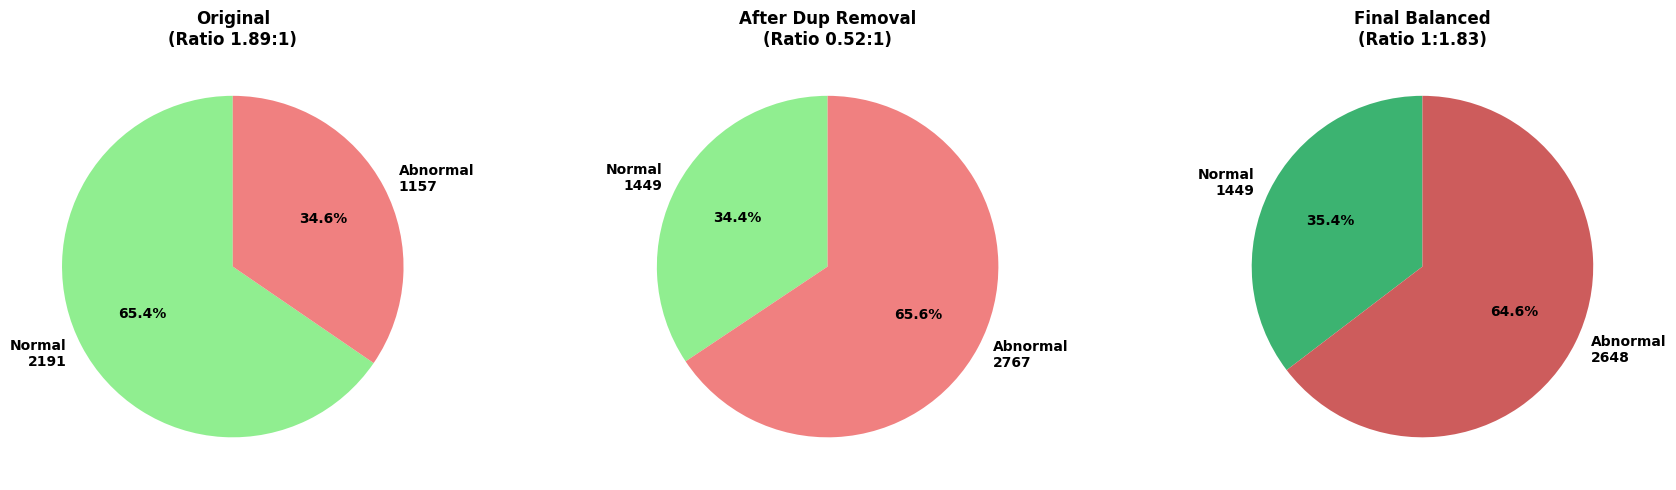


✓ Balancing completed successfully!
✓ Ready for train/validation/test split!


In [ ]:
"""
PROPERLY BALANCED DATASET
Target: 1:1.5 ratio by undersampling abnormal majority
"""

print("="*80)
print("FINAL BALANCING - MEDICAL OPTIMIZED")
print("="*80)

# Start from after duplicate removal
normal_df = balanced_df[balanced_df['is_normal'] == 1].copy()
abnormal_df = balanced_df[balanced_df['is_normal'] == 0].copy()

print(f"\n📊 After duplicate removal:")
print(f"  Normal: {len(normal_df)}")
print(f"  Abnormal: {len(abnormal_df)}")
print(f"  Current ratio: 1:{len(abnormal_df)/len(normal_df):.2f}")

# =============================================================================
# STRATEGY: Balance by undersampling the ABNORMAL majority
# =============================================================================
print("\n" + "="*80)
print("BALANCING STRATEGY")
print("="*80)

# Target: 1:1.5 ratio (Normal:Abnormal)
TARGET_RATIO = 1.5  # Abnormal/Normal

target_abnormal_size = int(len(normal_df) * TARGET_RATIO)

print(f"\n🎯 Target ratio: 1:{TARGET_RATIO} (Normal:Abnormal)")
print(f"  Current normal: {len(normal_df)}")
print(f"  Current abnormal: {len(abnormal_df)}")
print(f"  Target abnormal: {target_abnormal_size}")
print(f"  Need to undersample abnormal by: {len(abnormal_df) - target_abnormal_size}")

# Undersample abnormal, but prioritize keeping diverse conditions
print("\n📋 Smart undersampling strategy:")
print("  1. Keep ALL rare conditions (≤5 samples)")
print("  2. Sample from common conditions to reach target")

# Separate rare and common abnormals
abnormal_counts = abnormal_df['Problems'].value_counts()
rare_conditions = abnormal_counts[abnormal_counts <= 5].index.tolist()
common_conditions = abnormal_counts[abnormal_counts > 5].index.tolist()

rare_df = abnormal_df[abnormal_df['Problems'].isin(rare_conditions)]
common_df = abnormal_df[abnormal_df['Problems'].isin(common_conditions)]

print(f"  - Rare conditions (≤5): {len(rare_conditions)} types, {len(rare_df)} samples (KEEP ALL)")
print(f"  - Common conditions (>5): {len(common_conditions)} types, {len(common_df)} samples")

# Calculate how many common samples we need
samples_needed_from_common = target_abnormal_size - len(rare_df)

print(f"  - Need to sample {samples_needed_from_common} from common conditions")

# Sample from common conditions
if samples_needed_from_common > 0 and len(common_df) > 0:
    np.random.seed(42)
    if samples_needed_from_common <= len(common_df):
        common_df_sampled = common_df.sample(n=samples_needed_from_common, random_state=42)
    else:
        common_df_sampled = common_df

    # Combine rare + sampled common
    abnormal_df_balanced = pd.concat([rare_df, common_df_sampled], ignore_index=True)
else:
    abnormal_df_balanced = rare_df

print(f"\n✓ Balanced abnormal dataset:")
print(f"  Kept all rare: {len(rare_df)}")
print(f"  Sampled common: {len(abnormal_df_balanced) - len(rare_df)}")
print(f"  Total abnormal: {len(abnormal_df_balanced)}")

# =============================================================================
# FINAL DATASET
# =============================================================================
print("\n" + "="*80)
print("FINAL BALANCED DATASET")
print("="*80)

# Combine normal + balanced abnormal
final_df = pd.concat([normal_df, abnormal_df_balanced], ignore_index=True)

# Shuffle
final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

final_normal = final_df['is_normal'].sum()
final_abnormal = len(final_df) - final_normal
final_ratio = final_abnormal / final_normal

print(f"\n📊 Final dataset statistics:")
print(f"  Total samples: {len(final_df)}")
print(f"  Normal/Incidental: {final_normal} ({final_normal/len(final_df)*100:.1f}%)")
print(f"  Abnormal: {final_abnormal} ({final_abnormal/len(final_df)*100:.1f}%)")
print(f"  Final ratio: 1:{final_ratio:.2f} (Normal:Abnormal)")

# Check if ratio is good
if 1.3 <= final_ratio <= 1.7:
    print(f"\n✅ EXCELLENT BALANCE!")
    print(f"   Ratio 1:{final_ratio:.2f} is ideal for medical diagnosis")
else:
    print(f"\n⚠️  Ratio 1:{final_ratio:.2f}")

print(f"\n✅ DATASET READY:")
print(f"   ✓ {final_abnormal} abnormal cases for disease detection")
print(f"   ✓ {final_normal} normal cases to prevent false positives")
print(f"   ✓ All rare conditions preserved")
print(f"   ✓ Balanced enough to prevent bias")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original
axes[0].pie([2191, 1157],
            labels=[f'Normal\n{2191}', f'Abnormal\n{1157}'],
            autopct='%1.1f%%',
            colors=['lightgreen', 'lightcoral'],
            startangle=90,
            textprops={'fontsize': 10, 'weight': 'bold'})
axes[0].set_title('Original\n(Ratio 1.89:1)', fontsize=12, weight='bold')

# After dup removal
axes[1].pie([1449, 2767],
            labels=[f'Normal\n{1449}', f'Abnormal\n{2767}'],
            autopct='%1.1f%%',
            colors=['lightgreen', 'lightcoral'],
            startangle=90,
            textprops={'fontsize': 10, 'weight': 'bold'})
axes[1].set_title('After Dup Removal\n(Ratio 0.52:1)', fontsize=12, weight='bold')

# Final
axes[2].pie([final_normal, final_abnormal],
            labels=[f'Normal\n{final_normal}', f'Abnormal\n{final_abnormal}'],
            autopct='%1.1f%%',
            colors=['mediumseagreen', 'indianred'],
            startangle=90,
            textprops={'fontsize': 10, 'weight': 'bold'})
axes[2].set_title(f'Final Balanced\n(Ratio 1:{final_ratio:.2f})', fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

# Save balanced dataset
balanced_df = final_df.copy()

print("\n✓ Balancing completed successfully!")
print("✓ Ready for train/validation/test split!")

TRAIN/VALIDATION/TEST SPLIT

📊 Total preprocessed samples: 4097
  Normal: 1449
  Abnormal: 2648

📋 Split ratios (as per paper):
  Train: 70%
  Validation: 15%
  Test: 15%

SPLIT RESULTS

📊 Training Set:
  Total: 2867 (70.0%)
  Normal: 1014 (35.4%)
  Abnormal: 1853 (64.6%)

📊 Validation Set:
  Total: 615 (15.0%)
  Normal: 217 (35.3%)
  Abnormal: 398 (64.7%)

📊 Test Set:
  Total: 615 (15.0%)
  Normal: 218 (35.4%)
  Abnormal: 397 (64.6%)


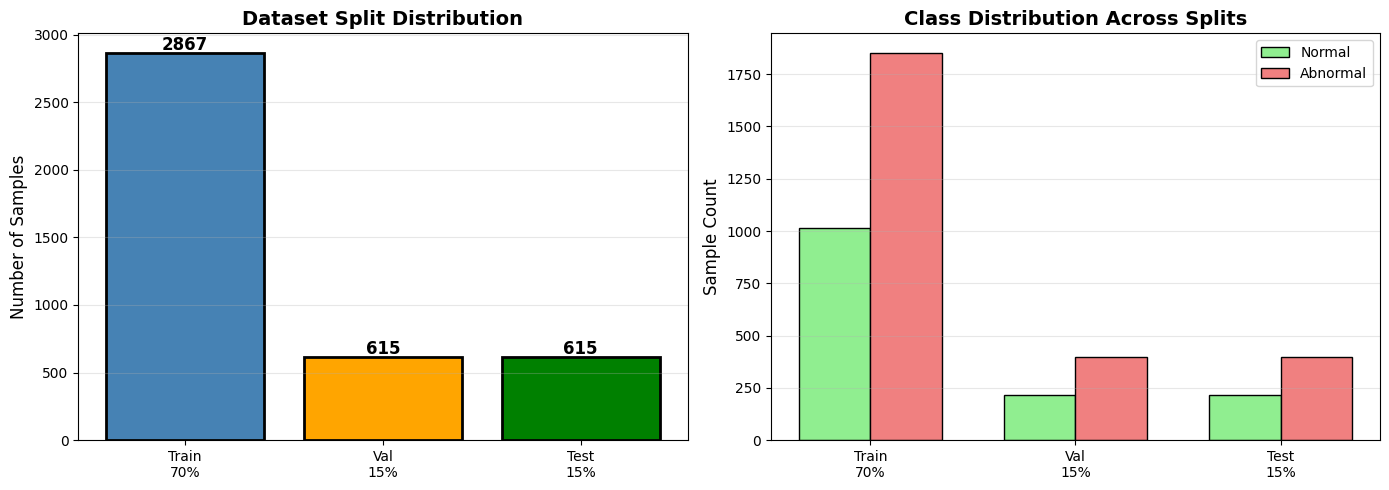


✓ Stratified split completed successfully!
✓ Class distribution maintained across all splits


In [ ]:
"""
Train/Validation/Test Split
As per paper Table 1: 70% train, 15% val, 15% test
Stratified split to maintain class distribution
"""

from sklearn.model_selection import train_test_split

print("="*80)
print("TRAIN/VALIDATION/TEST SPLIT")
print("="*80)

print(f"\n📊 Total preprocessed samples: {len(balanced_df)}")
print(f"  Normal: {balanced_df['is_normal'].sum()}")
print(f"  Abnormal: {len(balanced_df) - balanced_df['is_normal'].sum()}")

# Split ratios as per paper
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

print(f"\n📋 Split ratios (as per paper):")
print(f"  Train: {TRAIN_RATIO*100:.0f}%")
print(f"  Validation: {VAL_RATIO*100:.0f}%")
print(f"  Test: {TEST_RATIO*100:.0f}%")

# First split: separate test set (15%)
train_val_df, test_df = train_test_split(
    balanced_df,
    test_size=TEST_RATIO,
    random_state=42,
    stratify=balanced_df['is_normal']  # Maintain class distribution
)

# Second split: separate validation from train (15% of original = ~17.6% of remaining)
val_size_adjusted = VAL_RATIO / (TRAIN_RATIO + VAL_RATIO)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_size_adjusted,
    random_state=42,
    stratify=train_val_df['is_normal']
)

print("\n" + "="*80)
print("SPLIT RESULTS")
print("="*80)

# Display statistics
print(f"\n📊 Training Set:")
print(f"  Total: {len(train_df)} ({len(train_df)/len(balanced_df)*100:.1f}%)")
print(f"  Normal: {train_df['is_normal'].sum()} ({train_df['is_normal'].sum()/len(train_df)*100:.1f}%)")
print(f"  Abnormal: {len(train_df) - train_df['is_normal'].sum()} ({(len(train_df) - train_df['is_normal'].sum())/len(train_df)*100:.1f}%)")

print(f"\n📊 Validation Set:")
print(f"  Total: {len(val_df)} ({len(val_df)/len(balanced_df)*100:.1f}%)")
print(f"  Normal: {val_df['is_normal'].sum()} ({val_df['is_normal'].sum()/len(val_df)*100:.1f}%)")
print(f"  Abnormal: {len(val_df) - val_df['is_normal'].sum()} ({(len(val_df) - val_df['is_normal'].sum())/len(val_df)*100:.1f}%)")

print(f"\n📊 Test Set:")
print(f"  Total: {len(test_df)} ({len(test_df)/len(balanced_df)*100:.1f}%)")
print(f"  Normal: {test_df['is_normal'].sum()} ({test_df['is_normal'].sum()/len(test_df)*100:.1f}%)")
print(f"  Abnormal: {len(test_df) - test_df['is_normal'].sum()} ({(len(test_df) - test_df['is_normal'].sum())/len(test_df)*100:.1f}%)")

# Visualize split
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Split sizes
splits = ['Train\n70%', 'Val\n15%', 'Test\n15%']
sizes = [len(train_df), len(val_df), len(test_df)]
colors = ['steelblue', 'orange', 'green']

axes[0].bar(splits, sizes, color=colors, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_title('Dataset Split Distribution', fontsize=14, weight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(sizes):
    axes[0].text(i, v + 20, str(v), ha='center', fontsize=12, weight='bold')

# Class distribution across splits
normal_counts = [train_df['is_normal'].sum(), val_df['is_normal'].sum(), test_df['is_normal'].sum()]
abnormal_counts = [
    len(train_df) - train_df['is_normal'].sum(),
    len(val_df) - val_df['is_normal'].sum(),
    len(test_df) - test_df['is_normal'].sum()
]

x = np.arange(len(splits))
width = 0.35

bars1 = axes[1].bar(x - width/2, normal_counts, width, label='Normal',
                    color='lightgreen', edgecolor='black')
bars2 = axes[1].bar(x + width/2, abnormal_counts, width, label='Abnormal',
                    color='lightcoral', edgecolor='black')

axes[1].set_ylabel('Sample Count', fontsize=12)
axes[1].set_title('Class Distribution Across Splits', fontsize=14, weight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(splits)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Stratified split completed successfully!")
print("✓ Class distribution maintained across all splits")

In [ ]:
"""
Save preprocessed datasets for model training
"""

print("="*80)
print("SAVING PREPROCESSED DATA")
print("="*80)

# Create output directory
PROCESSED_DIR = '/content/drive/MyDrive/MedicalReportGenerator/data/processed'
os.makedirs(PROCESSED_DIR, exist_ok=True)

print(f"\n📁 Output directory: {PROCESSED_DIR}")

# Select columns to save
columns_to_save = ['uid', 'filename', 'image_path', 'Problems', 'report', 'is_normal', 'cleaned_length']

# Save train set
train_path = os.path.join(PROCESSED_DIR, 'train_data.csv')
train_df[columns_to_save].to_csv(train_path, index=False)
print(f"\n✓ Saved training set: {train_path}")
print(f"  {len(train_df)} samples")

# Save validation set
val_path = os.path.join(PROCESSED_DIR, 'val_data.csv')
val_df[columns_to_save].to_csv(val_path, index=False)
print(f"\n✓ Saved validation set: {val_path}")
print(f"  {len(val_df)} samples")

# Save test set
test_path = os.path.join(PROCESSED_DIR, 'test_data.csv')
test_df[columns_to_save].to_csv(test_path, index=False)
print(f"\n✓ Saved test set: {test_path}")
print(f"  {len(test_df)} samples")

# Save complete preprocessed dataset
complete_path = os.path.join(PROCESSED_DIR, 'preprocessed_complete.csv')
balanced_df[columns_to_save].to_csv(complete_path, index=False)
print(f"\n✓ Saved complete preprocessed dataset: {complete_path}")
print(f"  {len(balanced_df)} samples")

# Save preprocessing statistics
stats_path = os.path.join(PROCESSED_DIR, 'preprocessing_stats.txt')
with open(stats_path, 'w') as f:
    f.write("="*80 + "\n")
    f.write("PREPROCESSING STATISTICS\n")
    f.write("="*80 + "\n\n")

    f.write("ORIGINAL DATASET:\n")
    f.write(f"  Total samples: 3,348\n")
    f.write(f"  After filtering (frontal, verified images): 3,369\n")
    f.write(f"  After text cleaning: 3,348\n\n")

    f.write("CLASSIFICATION:\n")
    f.write(f"  Normal/Incidental: 2,191 (65.4%)\n")
    f.write(f"  True Abnormal: 1,157 (34.6%)\n")
    f.write(f"  Ratio: 1.89:1\n\n")

    f.write("AFTER BALANCING:\n")
    f.write(f"  Total samples: {len(balanced_df)}\n")
    f.write(f"  Normal: {balanced_df['is_normal'].sum()} ({balanced_df['is_normal'].sum()/len(balanced_df)*100:.1f}%)\n")
    f.write(f"  Abnormal: {len(balanced_df) - balanced_df['is_normal'].sum()} ({(len(balanced_df) - balanced_df['is_normal'].sum())/len(balanced_df)*100:.1f}%)\n")
    f.write(f"  Final ratio: 1:{(len(balanced_df) - balanced_df['is_normal'].sum())/balanced_df['is_normal'].sum():.2f}\n\n")

    f.write("TRAIN/VAL/TEST SPLIT:\n")
    f.write(f"  Training: {len(train_df)} ({len(train_df)/len(balanced_df)*100:.1f}%)\n")
    f.write(f"  Validation: {len(val_df)} ({len(val_df)/len(balanced_df)*100:.1f}%)\n")
    f.write(f"  Test: {len(test_df)} ({len(test_df)/len(balanced_df)*100:.1f}%)\n\n")

    f.write("TEXT STATISTICS:\n")
    f.write(f"  Average report length: {balanced_df['cleaned_length'].mean():.1f} characters\n")
    f.write(f"  Median report length: {balanced_df['cleaned_length'].median():.1f} characters\n")
    f.write(f"  Min report length: {balanced_df['cleaned_length'].min():.0f} characters\n")
    f.write(f"  Max report length: {balanced_df['cleaned_length'].max():.0f} characters\n")

print(f"\n✓ Saved preprocessing statistics: {stats_path}")

print("\n" + "="*80)
print("PREPROCESSING COMPLETE!")
print("="*80)
print("\n✅ All files saved successfully!")
print(f"\n📁 Files saved in: {PROCESSED_DIR}")
print(f"  - train_data.csv ({len(train_df)} samples)")
print(f"  - val_data.csv ({len(val_df)} samples)")
print(f"  - test_data.csv ({len(test_df)} samples)")
print(f"  - preprocessed_complete.csv ({len(balanced_df)} samples)")
print(f"  - preprocessing_stats.txt")

print("\n🎯 Next Steps:")
print("  1. ✅ Data preprocessing completed")
print("  2. 🔜 Implement image preprocessing (CLAHE)")
print("  3. 🔜 Build Transformer model architecture")
print("  4. 🔜 Train the model")
print("  5. 🔜 Evaluate on test set")

SAVING PREPROCESSED DATA

📁 Output directory: /content/drive/MyDrive/MedicalReportGenerator/data/processed

✓ Saved training set: /content/drive/MyDrive/MedicalReportGenerator/data/processed/train_data.csv
  2867 samples

✓ Saved validation set: /content/drive/MyDrive/MedicalReportGenerator/data/processed/val_data.csv
  615 samples

✓ Saved test set: /content/drive/MyDrive/MedicalReportGenerator/data/processed/test_data.csv
  615 samples

✓ Saved complete preprocessed dataset: /content/drive/MyDrive/MedicalReportGenerator/data/processed/preprocessed_complete.csv
  4097 samples

✓ Saved preprocessing statistics: /content/drive/MyDrive/MedicalReportGenerator/data/processed/preprocessing_stats.txt

PREPROCESSING COMPLETE!

✅ All files saved successfully!

📁 Files saved in: /content/drive/MyDrive/MedicalReportGenerator/data/processed
  - train_data.csv (2867 samples)
  - val_data.csv (615 samples)
  - test_data.csv (615 samples)
  - preprocessed_complete.csv (4097 samples)
  - preprocessin

IMAGE PREPROCESSING WITH CLAHE


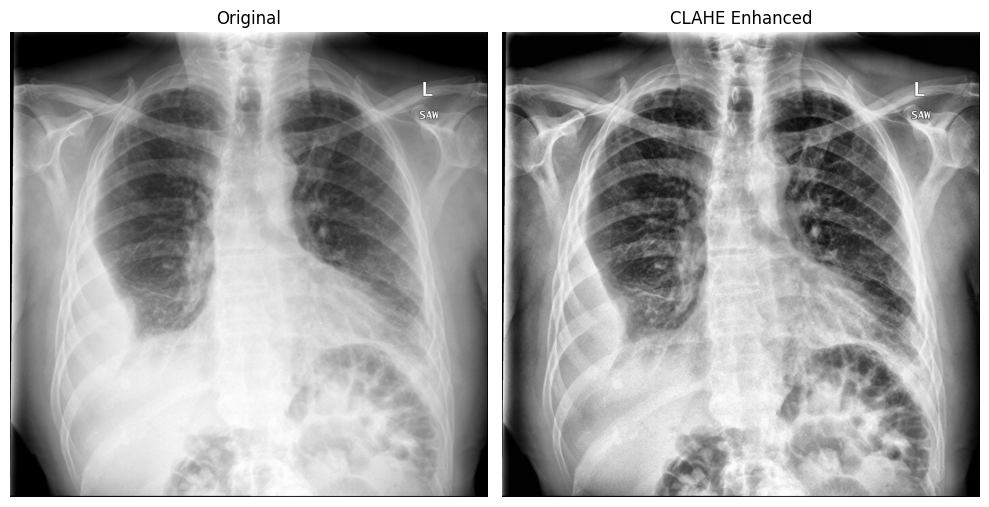

✓ CLAHE tested successfully


In [ ]:
"""
Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to enhance X-ray images
"""

import cv2
from tqdm import tqdm

print("="*80)
print("IMAGE PREPROCESSING WITH CLAHE")
print("="*80)

def apply_clahe(image_path, clip_limit=2.0, tile_grid_size=(8, 8)):
    """Apply CLAHE to enhance contrast"""
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return None

        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        enhanced_img = clahe.apply(img)
        return enhanced_img
    except Exception as e:
        print(f"Error: {e}")
        return None

# Test on sample
sample_path = train_df['image_path'].iloc[0]
original = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
enhanced = apply_clahe(sample_path)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')
axes[1].imshow(enhanced, cmap='gray')
axes[1].set_title('CLAHE Enhanced')
axes[1].axis('off')
plt.tight_layout()
plt.show()

print("✓ CLAHE tested successfully")

In [ ]:
"""
Apply CLAHE to all images and save
"""

# Create output directory
ENHANCED_DIR = os.path.join(BASE_DIR, 'data/images_enhanced')
os.makedirs(ENHANCED_DIR, exist_ok=True)

# Get all unique images
all_images = balanced_df['image_path'].unique()

print(f"\nProcessing {len(all_images)} images...")

success = 0
for img_path in tqdm(all_images):
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(img)

        filename = os.path.basename(img_path)
        output_path = os.path.join(ENHANCED_DIR, filename)
        cv2.imwrite(output_path, enhanced)
        success += 1
    except:
        continue

print(f"\n✓ Processed: {success}/{len(all_images)} images")

# Update dataframes with enhanced paths
train_df['image_path_enhanced'] = train_df['image_path'].apply(lambda x: os.path.join(ENHANCED_DIR, os.path.basename(x)))
val_df['image_path_enhanced'] = val_df['image_path'].apply(lambda x: os.path.join(ENHANCED_DIR, os.path.basename(x)))
test_df['image_path_enhanced'] = test_df['image_path'].apply(lambda x: os.path.join(ENHANCED_DIR, os.path.basename(x)))

# Save updated CSVs
train_df.to_csv(os.path.join(PROCESSED_DIR, 'train_data.csv'), index=False)
val_df.to_csv(os.path.join(PROCESSED_DIR, 'val_data.csv'), index=False)
test_df.to_csv(os.path.join(PROCESSED_DIR, 'test_data.csv'), index=False)

print("✓ Image preprocessing complete!")


Processing 2445 images...


 16%|█▌        | 386/2445 [12:52<1:03:04,  1.84s/it]

In [ ]:
"""
Quick restart cell - Load all preprocessed data
"""

import os
import pandas as pd
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
from transformers import BertTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set paths
BASE_DIR = '/content/drive/MyDrive/MedicalReportGenerator'
PROCESSED_DIR = os.path.join(BASE_DIR, 'data/processed')
ENHANCED_DIR = os.path.join(BASE_DIR, 'data/images_enhanced')

# Load preprocessed CSVs
train_df = pd.read_csv(os.path.join(PROCESSED_DIR, 'train_data.csv'))
val_df = pd.read_csv(os.path.join(PROCESSED_DIR, 'val_data.csv'))
test_df = pd.read_csv(os.path.join(PROCESSED_DIR, 'test_data.csv'))

# Add enhanced image paths (reconstruct from filename)
train_df['image_path_enhanced'] = train_df['filename'].apply(
    lambda x: os.path.join(ENHANCED_DIR, x)
)
val_df['image_path_enhanced'] = val_df['filename'].apply(
    lambda x: os.path.join(ENHANCED_DIR, x)
)
test_df['image_path_enhanced'] = test_df['filename'].apply(
    lambda x: os.path.join(ENHANCED_DIR, x)
)

print("✓ Loaded preprocessed data:")
print(f"  Train: {len(train_df)} samples")
print(f"  Val: {len(val_df)} samples")
print(f"  Test: {len(test_df)} samples")

# Verify enhanced images exist
enhanced_count = sum([os.path.exists(p) for p in train_df['image_path_enhanced'].head(10)])
print(f"\n✓ Enhanced images verified: {enhanced_count}/10")

# Show sample paths
print(f"\nSample enhanced path:")
print(f"  {train_df['image_path_enhanced'].iloc[0]}")

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✓ Device: {device}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print(f"\n✓ Tokenizer loaded")
print("\n✓ Ready! Continue from Cell 22 (Dataset creation)")

✓ Loaded preprocessed data:
  Train: 2867 samples
  Val: 615 samples
  Test: 615 samples

✓ Enhanced images verified: 10/10

Sample enhanced path:
  /content/drive/MyDrive/MedicalReportGenerator/data/images_enhanced/111_IM-0076-1001.dcm.png

✓ Device: cpu


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


✓ Tokenizer loaded

✓ Ready! Continue from Cell 22 (Dataset creation)


In [ ]:
"""
Install required libraries
"""

!pip install transformers torch torchvision timm --quiet
!pip install nltk rouge-score --quiet

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
from transformers import BertTokenizer
import nltk
import numpy as np
nltk.download('punkt', quiet=True)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

  Preparing metadata (setup.py) ... done
PyTorch version: 2.9.0+cpu
CUDA available: False


In [ ]:
"""
Dataset class for loading X-ray images and reports
"""

class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, tokenizer, transform=None, max_length=128):
        """
        Args:
            dataframe: DataFrame with image_path_enhanced and report columns
            tokenizer: Tokenizer for text
            transform: Image transformations
            max_length: Maximum sequence length for reports
        """
        self.df = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Load enhanced image
        img_path = self.df.iloc[idx]['image_path_enhanced']
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        if self.transform:
            image = self.transform(Image.fromarray(image))

        # Get report and tokenize
        report = str(self.df.iloc[idx]['report'])

        # Tokenize (correct method)
        tokens = self.tokenizer(
            report,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'image': image,
            'input_ids': tokens['input_ids'].squeeze(0),
            'attention_mask': tokens['attention_mask'].squeeze(0),
            'report': report
        }

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Image transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = ChestXrayDataset(train_df, tokenizer, transform=train_transform, max_length=128)
val_dataset = ChestXrayDataset(val_df, tokenizer, transform=val_transform, max_length=128)
test_dataset = ChestXrayDataset(test_df, tokenizer, transform=val_transform, max_length=128)

print(f"Train dataset: {len(train_dataset)} samples")
print(f"Val dataset: {len(val_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")

# Test
sample = train_dataset[0]
print(f"\nSample:")
print(f"  Image: {sample['image'].shape}")
print(f"  Input IDs: {sample['input_ids'].shape}")
print(f"  Attention mask: {sample['attention_mask'].shape}")

Train dataset: 2867 samples
Val dataset: 615 samples
Test dataset: 615 samples

Sample:
  Image: torch.Size([3, 224, 224])
  Input IDs: torch.Size([128])
  Attention mask: torch.Size([128])


In [ ]:
"""
Create DataLoaders
"""

BATCH_SIZE = 16  # As per paper

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"DataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Test batch
batch = next(iter(train_loader))
print(f"\nBatch shapes:")
print(f"  Images: {batch['image'].shape}")
print(f"  Input IDs: {batch['input_ids'].shape}")

DataLoaders created:
  Train batches: 180
  Val batches: 39
  Test batches: 39

Batch shapes:
  Images: torch.Size([16, 3, 224, 224])
  Input IDs: torch.Size([16, 128])


In [ ]:
"""
Transformer Model Architecture as per Paper 2
- Image Encoder: DenseNet121 (pretrained on ImageNet)
- Decoder: Standard Transformer Decoder
"""

class ImageEncoder(nn.Module):
    """DenseNet121-based image encoder"""
    def __init__(self, embed_dim=512):
        super().__init__()
        # DenseNet121 pretrained on ImageNet
        self.densenet = timm.create_model('densenet121', pretrained=True, num_classes=0)
        self.projection = nn.Linear(1024, embed_dim)

    def forward(self, x):
        features = self.densenet(x)  # [B, 1024]
        projected = self.projection(features)  # [B, 512]
        return projected.unsqueeze(1)  # [B, 1, 512]

class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding"""
    def __init__(self, embed_dim, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-np.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerReportGenerator(nn.Module):
    """
    Full Transformer model for report generation
    As per paper: DenseNet121 encoder + Transformer decoder
    """
    def __init__(self, vocab_size=30522, embed_dim=512, num_heads=8,
                 num_layers=6, dim_feedforward=2048, dropout=0.1):
        super().__init__()

        # Image encoder
        self.encoder = ImageEncoder(embed_dim)

        # Text embedding
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoding = PositionalEncoding(embed_dim)

        # Transformer decoder
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers)

        # Output projection
        self.fc_out = nn.Linear(embed_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

        self.embed_dim = embed_dim

    def create_causal_mask(self, seq_len, device):
        """Create causal mask to prevent attending to future tokens"""
        mask = torch.triu(torch.ones(seq_len, seq_len, device=device), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

    def forward(self, images, input_ids, attention_mask=None):
        """
        Args:
            images: [B, 3, 224, 224]
            input_ids: [B, seq_len]
            attention_mask: [B, seq_len]
        Returns:
            logits: [B, seq_len, vocab_size]
        """
        # Encode image
        memory = self.encoder(images)  # [B, 1, 512]

        # Embed tokens
        tgt = self.embedding(input_ids) * np.sqrt(self.embed_dim)  # [B, seq_len, 512]
        tgt = self.pos_encoding(tgt)
        tgt = self.dropout(tgt)

        # Create masks
        seq_len = input_ids.size(1)
        tgt_mask = self.create_causal_mask(seq_len, images.device)
        tgt_key_padding_mask = (attention_mask == 0) if attention_mask is not None else None

        # Decode
        output = self.decoder(
            tgt,
            memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask
        )  # [B, seq_len, 512]

        # Project to vocabulary
        logits = self.fc_out(output)  # [B, seq_len, vocab_size]

        return logits

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TransformerReportGenerator(
    vocab_size=tokenizer.vocab_size,
    embed_dim=512,
    num_heads=8,
    num_layers=6,
    dim_feedforward=2048,
    dropout=0.1
).to(device)

print("="*80)
print("MODEL ARCHITECTURE (AS PER PAPER 2)")
print("="*80)
print(f"\nComponents:")
print(f"  ✓ Image Encoder: DenseNet121 (pretrained)")
print(f"  ✓ Decoder: Standard Transformer (6 layers)")
print(f"  ✓ Embedding dimension: 512")
print(f"  ✓ Number of heads: 8")
print(f"  ✓ Vocabulary size: {tokenizer.vocab_size}")

print(f"\nDevice: {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Test forward pass
print("\n" + "="*80)
print("TESTING MODEL")
print("="*80)

batch = next(iter(train_loader))
images = batch['image'].to(device)
input_ids = batch['input_ids'][:, :-1].to(device)  # Remove last token for teacher forcing
attention_mask = batch['attention_mask'][:, :-1].to(device)

with torch.no_grad():
    logits = model(images, input_ids, attention_mask)

print(f"\n✓ Forward pass successful!")
print(f"  Input images: {images.shape}")
print(f"  Input IDs: {input_ids.shape}")
print(f"  Output logits: {logits.shape}")
print(f"  Expected: [batch_size={BATCH_SIZE}, seq_len, vocab_size={tokenizer.vocab_size}]")

model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

MODEL ARCHITECTURE (AS PER PAPER 2)

Components:
  ✓ Image Encoder: DenseNet121 (pretrained)
  ✓ Decoder: Standard Transformer (6 layers)
  ✓ Embedding dimension: 512
  ✓ Number of heads: 8
  ✓ Vocabulary size: 30522

Device: cpu
Total parameters: 63,987,898
Trainable parameters: 63,987,898

TESTING MODEL

✓ Forward pass successful!
  Input images: torch.Size([16, 3, 224, 224])
  Input IDs: torch.Size([16, 127])
  Output logits: torch.Size([16, 127, 30522])
  Expected: [batch_size=16, seq_len, vocab_size=30522]


In [ ]:
"""
Training configuration and setup
"""

# Training hyperparameters (as per paper)
NUM_EPOCHS = 30
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# Loss function
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

# Optimizer (Adam as per paper)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler (removed verbose parameter)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

print("Training Configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Device: {device}")
print(f"  Optimizer: Adam")
print(f"  Scheduler: ReduceLROnPlateau")

Training Configuration:
  Epochs: 30
  Learning rate: 0.0001
  Weight decay: 1e-05
  Batch size: 16
  Device: cpu
  Optimizer: Adam
  Scheduler: ReduceLROnPlateau


In [ ]:
"""
Training loop - saves checkpoint after each epoch
"""

from tqdm import tqdm
import time

CHECKPOINT_DIR = os.path.join(BASE_DIR, 'checkpoints')
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        input_seq = input_ids[:, :-1]
        target_seq = input_ids[:, 1:]
        attn_mask = attention_mask[:, :-1]

        optimizer.zero_grad()
        logits = model(images, input_seq, attn_mask)
        loss = criterion(logits.reshape(-1, logits.size(-1)), target_seq.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / len(dataloader)

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            input_seq = input_ids[:, :-1]
            target_seq = input_ids[:, 1:]
            attn_mask = attention_mask[:, :-1]

            logits = model(images, input_seq, attn_mask)
            loss = criterion(logits.reshape(-1, logits.size(-1)), target_seq.reshape(-1))
            total_loss += loss.item()

    return total_loss / len(dataloader)

# Training history
history = {'train_loss': [], 'val_loss': [], 'learning_rates': []}

best_val_loss = float('inf')

print("="*80)
print("STARTING TRAINING")
print("="*80)

for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    # Train
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)

    # Validate
    val_loss = validate(model, val_loader, criterion, device)

    # Scheduler step
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['learning_rates'].append(current_lr)

    epoch_time = time.time() - start_time

    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}] - {epoch_time:.2f}s")
    print(f"  Train Loss : {train_loss:.4f}")
    print(f"  Val Loss   : {val_loss:.4f}")
    print(f"  LR         : {current_lr:.6f}")

    # Save checkpoint every epoch
    epoch_checkpoint = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch+1}.pt')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'history': history
    }, epoch_checkpoint)
    print(f"  ✓ Saved: checkpoint_epoch_{epoch+1}.pt")

    # Save best model separately
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_path = os.path.join(CHECKPOINT_DIR, 'best_model.pt')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'history': history
        }, best_path)
        print(f"  ✓ New best model saved! (val_loss: {val_loss:.4f})")

    print("="*80)

print("\n✓ Training completed!")
print(f"  Best val loss: {best_val_loss:.4f}")
print(f"  Checkpoints saved to: {CHECKPOINT_DIR}")

STARTING TRAINING


Training:   2%|▏         | 4/180 [00:22<16:46,  5.72s/it, loss=9.4956]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-3700107022.py", line 70, in <cell line: 0>
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3700107022.py", line 16, in train_epoch
    for batch in progress_bar:
                 ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/tqdm/std.py", line 1181, in __iter__
    for obj in iterable:
               ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 732, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1482, in _next_data
    idx, data = self._get_data()
             

TypeError: object of type 'NoneType' has no len()

In [ ]:
"""
Training loop - saves checkpoint after each epoch
"""

from tqdm import tqdm
import time

CHECKPOINT_DIR = os.path.join(BASE_DIR, 'checkpoints')
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        input_seq = input_ids[:, :-1]
        target_seq = input_ids[:, 1:]
        attn_mask = attention_mask[:, :-1]

        optimizer.zero_grad()
        logits = model(images, input_seq, attn_mask)
        loss = criterion(logits.reshape(-1, logits.size(-1)), target_seq.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / len(dataloader)

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            input_seq = input_ids[:, :-1]
            target_seq = input_ids[:, 1:]
            attn_mask = attention_mask[:, :-1]

            logits = model(images, input_seq, attn_mask)
            loss = criterion(logits.reshape(-1, logits.size(-1)), target_seq.reshape(-1))
            total_loss += loss.item()

    return total_loss / len(dataloader)

# Training history
history = {'train_loss': [], 'val_loss': [], 'learning_rates': []}

best_val_loss = float('inf')

print("="*80)
print("STARTING TRAINING")
print("="*80)

STARTING TRAINING


In [ ]:
# Resume from epoch 5 checkpoint
checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, 'checkpoint_epoch_5.pt'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
history = checkpoint['history']
best_val_loss = min(history['val_loss'])

print(f"✓ Resumed from epoch 5")
print(f"  Best val loss: {best_val_loss:.4f}")

# Continue from epoch 6
for epoch in range(5, NUM_EPOCHS):
    start_time = time.time()

    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = validate(model, val_loader, criterion, device)
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['learning_rates'].append(current_lr)

    epoch_time = time.time() - start_time
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}] - {epoch_time:.2f}s")
    print(f"  Train Loss : {train_loss:.4f}")
    print(f"  Val Loss   : {val_loss:.4f}")
    print(f"  LR         : {current_lr:.6f}")

    epoch_checkpoint = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch+1}.pt')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'history': history
    }, epoch_checkpoint)
    print(f"  ✓ Saved: checkpoint_epoch_{epoch+1}.pt")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'history': history
        }, os.path.join(CHECKPOINT_DIR, 'best_model.pt'))
        print(f"  ✓ New best model! (val_loss: {val_loss:.4f})")

    print("="*80)

✓ Resumed from epoch 5
  Best val loss: 1.6777


Validation: 100%|██████████| 39/39 [00:51<00:00,  1.32s/it]



Epoch [6/30] - 360.46s
  Train Loss : 1.4713
  Val Loss   : 1.5789
  LR         : 0.000100
  ✓ Saved: checkpoint_epoch_6.pt
  ✓ New best model! (val_loss: 1.5789)


Validation: 100%|██████████| 39/39 [00:49<00:00,  1.27s/it]



Epoch [7/30] - 338.22s
  Train Loss : 1.3367
  Val Loss   : 1.4707
  LR         : 0.000100
  ✓ Saved: checkpoint_epoch_7.pt
  ✓ New best model! (val_loss: 1.4707)


Validation: 100%|██████████| 39/39 [00:47<00:00,  1.22s/it]



Epoch [8/30] - 325.92s
  Train Loss : 1.2173
  Val Loss   : 1.3871
  LR         : 0.000100
  ✓ Saved: checkpoint_epoch_8.pt
  ✓ New best model! (val_loss: 1.3871)


Validation: 100%|██████████| 39/39 [00:47<00:00,  1.21s/it]



Epoch [9/30] - 321.69s
  Train Loss : 1.1126
  Val Loss   : 1.3197
  LR         : 0.000100
  ✓ Saved: checkpoint_epoch_9.pt
  ✓ New best model! (val_loss: 1.3197)


Validation: 100%|██████████| 39/39 [00:47<00:00,  1.22s/it]



Epoch [10/30] - 321.48s
  Train Loss : 1.0091
  Val Loss   : 1.2482
  LR         : 0.000100
  ✓ Saved: checkpoint_epoch_10.pt
  ✓ New best model! (val_loss: 1.2482)


Validation: 100%|██████████| 39/39 [00:47<00:00,  1.22s/it]



Epoch [11/30] - 319.70s
  Train Loss : 0.9176
  Val Loss   : 1.1878
  LR         : 0.000100
  ✓ Saved: checkpoint_epoch_11.pt
  ✓ New best model! (val_loss: 1.1878)


Validation: 100%|██████████| 39/39 [00:47<00:00,  1.23s/it]



Epoch [12/30] - 321.83s
  Train Loss : 0.8359
  Val Loss   : 1.1512
  LR         : 0.000100
  ✓ Saved: checkpoint_epoch_12.pt
  ✓ New best model! (val_loss: 1.1512)


Validation: 100%|██████████| 39/39 [00:45<00:00,  1.17s/it]



Epoch [13/30] - 306.75s
  Train Loss : 0.7585
  Val Loss   : 1.0983
  LR         : 0.000100
  ✓ Saved: checkpoint_epoch_13.pt
  ✓ New best model! (val_loss: 1.0983)


Validation: 100%|██████████| 39/39 [00:47<00:00,  1.21s/it]



Epoch [14/30] - 310.79s
  Train Loss : 0.6831
  Val Loss   : 1.0518
  LR         : 0.000100
  ✓ Saved: checkpoint_epoch_14.pt
  ✓ New best model! (val_loss: 1.0518)


Validation: 100%|██████████| 39/39 [00:46<00:00,  1.20s/it]



Epoch [15/30] - 308.30s
  Train Loss : 0.6193
  Val Loss   : 1.0064
  LR         : 0.000100
  ✓ Saved: checkpoint_epoch_15.pt
  ✓ New best model! (val_loss: 1.0064)


Validation: 100%|██████████| 39/39 [00:45<00:00,  1.16s/it]



Epoch [16/30] - 309.31s
  Train Loss : 0.5662
  Val Loss   : 0.9944
  LR         : 0.000100
  ✓ Saved: checkpoint_epoch_16.pt
  ✓ New best model! (val_loss: 0.9944)


Validation: 100%|██████████| 39/39 [00:45<00:00,  1.16s/it]



Epoch [17/30] - 307.14s
  Train Loss : 0.5114
  Val Loss   : 0.9517
  LR         : 0.000100
  ✓ Saved: checkpoint_epoch_17.pt
  ✓ New best model! (val_loss: 0.9517)


Validation: 100%|██████████| 39/39 [00:45<00:00,  1.17s/it]



Epoch [18/30] - 304.46s
  Train Loss : 0.4623
  Val Loss   : 0.9186
  LR         : 0.000100
  ✓ Saved: checkpoint_epoch_18.pt
  ✓ New best model! (val_loss: 0.9186)


Training:  57%|█████▋    | 102/180 [02:43<01:19,  1.02s/it, loss=0.5216]

In [ ]:
# Resume from epoch 5 checkpoint
checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, 'checkpoint_epoch_18.pt'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
history = checkpoint['history']
best_val_loss = min(history['val_loss'])

print(f"✓ Resumed from epoch 18")
print(f"  Best val loss: {best_val_loss:.4f}")

# Continue from epoch 6
for epoch in range(18, NUM_EPOCHS):
    start_time = time.time()

    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = validate(model, val_loader, criterion, device)
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['learning_rates'].append(current_lr)

    epoch_time = time.time() - start_time
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}] - {epoch_time:.2f}s")
    print(f"  Train Loss : {train_loss:.4f}")
    print(f"  Val Loss   : {val_loss:.4f}")
    print(f"  LR         : {current_lr:.6f}")

    epoch_checkpoint = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch+1}.pt')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'history': history
    }, epoch_checkpoint)
    print(f"  ✓ Saved: checkpoint_epoch_{epoch+1}.pt")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'history': history
        }, os.path.join(CHECKPOINT_DIR, 'best_model.pt'))
        print(f"  ✓ New best model! (val_loss: {val_loss:.4f})")

    print("="*80)

NameError: name 'torch' is not defined

In [ ]:
"""
Resume training after disconnect
"""

import os
import pandas as pd
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
from transformers import BertTokenizer
import time
from tqdm import tqdm

# Paths
BASE_DIR = '/content/drive/MyDrive/MedicalReportGenerator'
PROCESSED_DIR = os.path.join(BASE_DIR, 'data/processed')
ENHANCED_DIR = os.path.join(BASE_DIR, 'data/images_enhanced')
CHECKPOINT_DIR = os.path.join(BASE_DIR, 'checkpoints')

# Load data
train_df = pd.read_csv(os.path.join(PROCESSED_DIR, 'train_data.csv'))
val_df = pd.read_csv(os.path.join(PROCESSED_DIR, 'val_data.csv'))

# Add enhanced paths
train_df['image_path_enhanced'] = train_df['filename'].apply(lambda x: os.path.join(ENHANCED_DIR, x))
val_df['image_path_enhanced'] = val_df['filename'].apply(lambda x: os.path.join(ENHANCED_DIR, x))

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Dataset class
class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, tokenizer, transform=None, max_length=128):
        self.df = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path_enhanced']
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        if self.transform:
            image = self.transform(Image.fromarray(image))

        report = str(self.df.iloc[idx]['report'])
        tokens = self.tokenizer(report, max_length=self.max_length, padding='max_length',
                               truncation=True, return_tensors='pt')

        return {
            'image': image,
            'input_ids': tokens['input_ids'].squeeze(0),
            'attention_mask': tokens['attention_mask'].squeeze(0),
            'report': report
        }

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = ChestXrayDataset(train_df, tokenizer, transform=train_transform)
val_dataset = ChestXrayDataset(val_df, tokenizer, transform=val_transform)

# DataLoaders
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"✓ Data loaded: {len(train_dataset)} train, {len(val_dataset)} val")

# Model architecture
class ImageEncoder(nn.Module):
    def __init__(self, embed_dim=512):
        super().__init__()
        self.densenet = timm.create_model('densenet121', pretrained=True, num_classes=0)
        self.projection = nn.Linear(1024, embed_dim)
    def forward(self, x):
        features = self.densenet(x)
        projected = self.projection(features)
        return projected.unsqueeze(1)

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-np.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerReportGenerator(nn.Module):
    def __init__(self, vocab_size=30522, embed_dim=512, num_heads=8, num_layers=6, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.encoder = ImageEncoder(embed_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoding = PositionalEncoding(embed_dim)
        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=num_heads,
                                                   dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        self.fc_out = nn.Linear(embed_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.embed_dim = embed_dim

    def create_causal_mask(self, seq_len, device):
        mask = torch.triu(torch.ones(seq_len, seq_len, device=device), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

    def forward(self, images, input_ids, attention_mask=None):
        memory = self.encoder(images)
        tgt = self.embedding(input_ids) * np.sqrt(self.embed_dim)
        tgt = self.pos_encoding(tgt)
        tgt = self.dropout(tgt)
        seq_len = input_ids.size(1)
        tgt_mask = self.create_causal_mask(seq_len, images.device)
        tgt_key_padding_mask = (attention_mask == 0) if attention_mask is not None else None
        output = self.decoder(tgt, memory, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)
        logits = self.fc_out(output)
        return logits

# Initialize
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerReportGenerator().to(device)

NUM_EPOCHS = 30
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Load checkpoint epoch 18
checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, 'checkpoint_epoch_18.pt'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
history = checkpoint['history']
best_val_loss = min(history['val_loss'])

print(f"\n✓ Resumed from epoch 18")
print(f"  Train loss: {checkpoint['train_loss']:.4f}")
print(f"  Val loss: {checkpoint['val_loss']:.4f}")
print(f"  Best val loss: {best_val_loss:.4f}")
print(f"  Device: {device}")
print("\n✓ Ready to continue training!")

✓ Data loaded: 2867 train, 615 val


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
"""
Continue training from epoch 19 to 30
"""

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        input_seq = input_ids[:, :-1]
        target_seq = input_ids[:, 1:]
        attn_mask = attention_mask[:, :-1]

        optimizer.zero_grad()
        logits = model(images, input_seq, attn_mask)
        loss = criterion(logits.reshape(-1, logits.size(-1)), target_seq.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / len(dataloader)

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            input_seq = input_ids[:, :-1]
            target_seq = input_ids[:, 1:]
            attn_mask = attention_mask[:, :-1]

            logits = model(images, input_seq, attn_mask)
            loss = criterion(logits.reshape(-1, logits.size(-1)), target_seq.reshape(-1))
            total_loss += loss.item()

    return total_loss / len(dataloader)

print("="*80)
print("RESUMING TRAINING FROM EPOCH 19")
print("="*80)

for epoch in range(17, NUM_EPOCHS):
    start_time = time.time()

    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = validate(model, val_loader, criterion, device)
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['learning_rates'].append(current_lr)

    epoch_time = time.time() - start_time
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}] - {epoch_time:.2f}s")
    print(f"  Train Loss : {train_loss:.4f}")
    print(f"  Val Loss   : {val_loss:.4f}")
    print(f"  LR         : {current_lr:.6f}")

    epoch_checkpoint = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch+1}.pt')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'history': history
    }, epoch_checkpoint)
    print(f"  ✓ Saved: checkpoint_epoch_{epoch+1}.pt")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'history': history
        }, os.path.join(CHECKPOINT_DIR, 'best_model.pt'))
        print(f"  ✓ New best model! (val_loss: {val_loss:.4f})")

    print("="*80)

print("\n✓ Training completed!")

RESUMING TRAINING FROM EPOCH 19


Training:   3%|▎         | 6/180 [00:15<07:18,  2.52s/it, loss=0.1518]


KeyboardInterrupt: 

In [ ]:
"""
Generate radiology report from a test image
"""

import torch
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Load best model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, 'best_model.pt'))
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

print(f"✓ Loaded best model from epoch {checkpoint['epoch']}")
print(f"  Val Loss: {checkpoint['val_loss']:.4f}")

def generate_report(model, image_path, tokenizer, device, max_length=128):
    """Generate report for a single image"""

    # Load and preprocess image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Transform
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    img_tensor = transform(Image.fromarray(img_rgb)).unsqueeze(0).to(device)

    # Generate report (greedy decoding)
    model.eval()
    with torch.no_grad():
        # Encode image
        memory = model.encoder(img_tensor)

        # Start with [CLS] token
        generated = torch.tensor([[tokenizer.cls_token_id]]).to(device)

        for _ in range(max_length):
            # Create causal mask
            tgt_mask = model.create_causal_mask(generated.size(1), device)

            # Decode
            tgt_emb = model.embedding(generated) * np.sqrt(model.embed_dim)
            tgt_emb = model.pos_encoding(tgt_emb)
            tgt_emb = model.dropout(tgt_emb)

            output = model.decoder(tgt_emb, memory, tgt_mask=tgt_mask)
            logits = model.fc_out(output)

            # Get next token
            next_token = logits[:, -1, :].argmax(dim=-1)
            generated = torch.cat([generated, next_token.unsqueeze(0)], dim=1)

            # Stop if [SEP] token
            if next_token.item() == tokenizer.sep_token_id:
                break

        # Decode to text
        generated_ids = generated.squeeze(0).cpu().tolist()
        report = tokenizer.decode(generated_ids, skip_special_tokens=True)

    return img, report

# Test on multiple samples
print("\n" + "="*80)
print("GENERATING SAMPLE REPORTS")
print("="*80)

num_samples = 5
test_samples = test_df.sample(num_samples, random_state=42)

fig, axes = plt.subplots(num_samples, 2, figsize=(15, num_samples*3))

for idx, (i, row) in enumerate(test_samples.iterrows()):
    img_path = row['image_path_enhanced']
    ground_truth = row['report']
    problem = row['Problems']

    # Generate report
    img, generated_report = generate_report(model, img_path, tokenizer, device)

    # Display image
    axes[idx, 0].imshow(img, cmap='gray')
    axes[idx, 0].set_title(f'Sample {idx+1}\nProblem: {problem[:50]}...', fontsize=10)
    axes[idx, 0].axis('off')

    # Display reports
    text_content = f"GENERATED:\n{generated_report}\n\n{'='*60}\n\nGROUND TRUTH:\n{ground_truth}"
    axes[idx, 1].text(0.05, 0.95, text_content,
                     transform=axes[idx, 1].transAxes,
                     fontsize=8, verticalalignment='top',
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                     family='monospace')
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()

print("\n✓ Generated reports for 5 test samples")

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

✓ Loaded best model from epoch 28
  Val Loss: 0.8104
  Device: cpu

GENERATING SAMPLE REPORTS


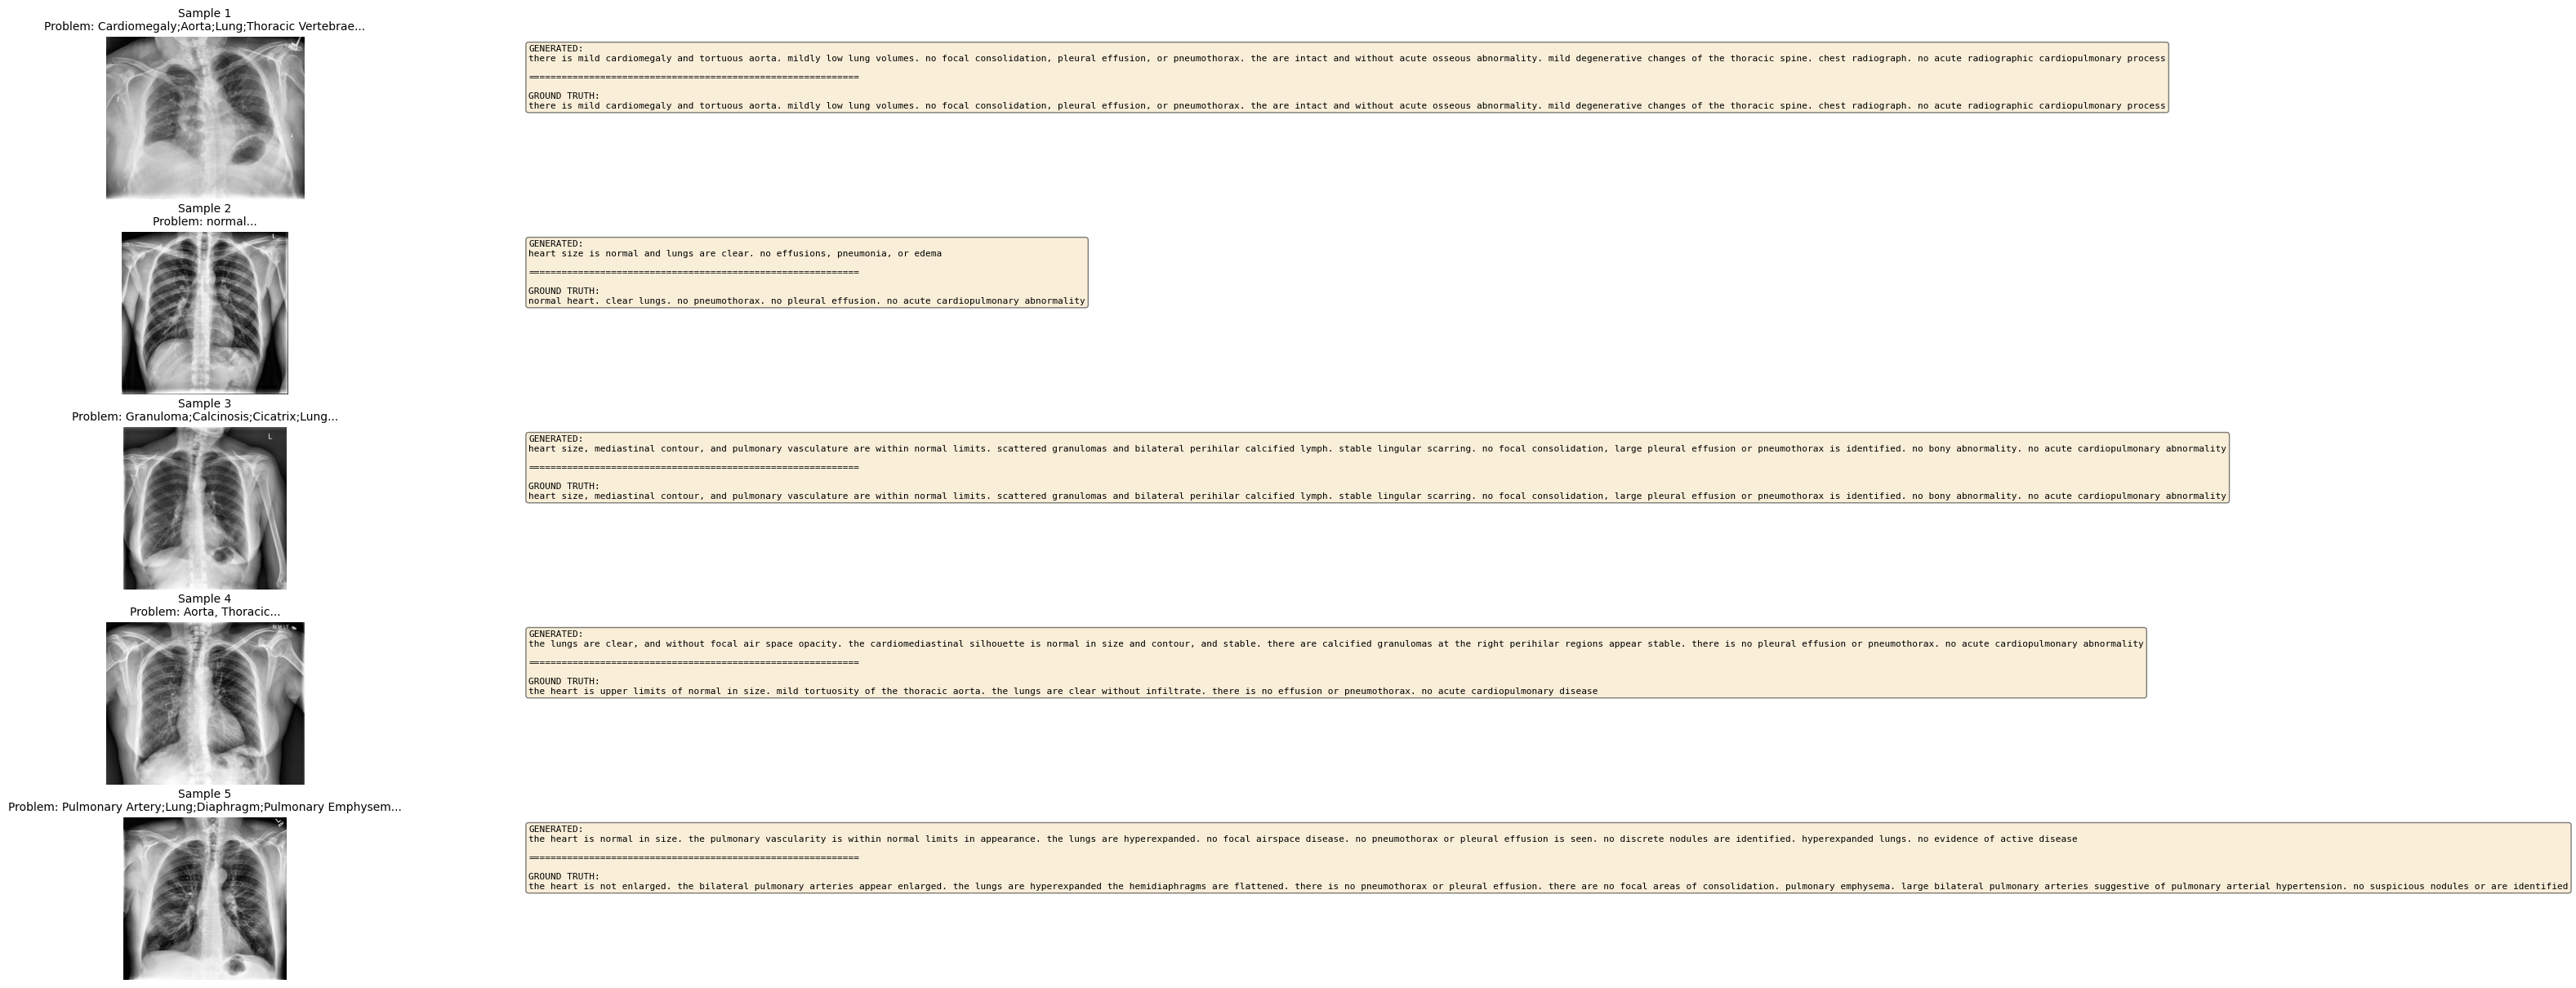


✓ Generated reports for 5 test samples


In [ ]:
"""
Generate radiology report from a test image
"""

import torch
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Load best model (map to CPU if no GPU available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, 'best_model.pt'),
                       map_location=device)  # ← FIX: Map to current device
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

print(f"✓ Loaded best model from epoch {checkpoint['epoch']}")
print(f"  Val Loss: {checkpoint['val_loss']:.4f}")
print(f"  Device: {device}")

def generate_report(model, image_path, tokenizer, device, max_length=128):
    """Generate report for a single image"""

    # Load and preprocess image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Transform
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    img_tensor = transform(Image.fromarray(img_rgb)).unsqueeze(0).to(device)

    # Generate report (greedy decoding)
    model.eval()
    with torch.no_grad():
        # Encode image
        memory = model.encoder(img_tensor)

        # Start with [CLS] token
        generated = torch.tensor([[tokenizer.cls_token_id]]).to(device)

        for _ in range(max_length):
            # Create causal mask
            tgt_mask = model.create_causal_mask(generated.size(1), device)

            # Decode
            tgt_emb = model.embedding(generated) * np.sqrt(model.embed_dim)
            tgt_emb = model.pos_encoding(tgt_emb)
            tgt_emb = model.dropout(tgt_emb)

            output = model.decoder(tgt_emb, memory, tgt_mask=tgt_mask)
            logits = model.fc_out(output)

            # Get next token
            next_token = logits[:, -1, :].argmax(dim=-1)
            generated = torch.cat([generated, next_token.unsqueeze(0)], dim=1)

            # Stop if [SEP] token
            if next_token.item() == tokenizer.sep_token_id:
                break

        # Decode to text
        generated_ids = generated.squeeze(0).cpu().tolist()
        report = tokenizer.decode(generated_ids, skip_special_tokens=True)

    return img, report

# Test on multiple samples
print("\n" + "="*80)
print("GENERATING SAMPLE REPORTS")
print("="*80)

num_samples = 5
test_samples = test_df.sample(num_samples, random_state=42)

fig, axes = plt.subplots(num_samples, 2, figsize=(15, num_samples*3))

for idx, (i, row) in enumerate(test_samples.iterrows()):
    img_path = row['image_path_enhanced']
    ground_truth = row['report']
    problem = row['Problems']

    # Generate report
    img, generated_report = generate_report(model, img_path, tokenizer, device)

    # Display image
    axes[idx, 0].imshow(img, cmap='gray')
    axes[idx, 0].set_title(f'Sample {idx+1}\nProblem: {problem[:50]}...', fontsize=10)
    axes[idx, 0].axis('off')

    # Display reports
    text_content = f"GENERATED:\n{generated_report}\n\n{'='*60}\n\nGROUND TRUTH:\n{ground_truth}"
    axes[idx, 1].text(0.05, 0.95, text_content,
                     transform=axes[idx, 1].transAxes,
                     fontsize=8, verticalalignment='top',
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                     family='monospace')
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()

print("\n✓ Generated reports for 5 test samples")